# Data

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [259]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [260]:
import csv
import datetime
import contextlib

import pickle
import scipy.sparse
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, classification_report

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('poster')
#sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')

## Import data

In [261]:
with open('refit_redd_fl_no_harmonization_with_tv_dishwasher_refit.pk', 'rb') as f:
    data = pickle.load(f)


# **Algorithms & Params**

In [262]:
#import sys
#sys.path.insert(0, "/content/drive/My Drive/Federated Learning")

from DDSC import *

In [292]:
def nnsc_train_block(train, B_ini, appliance_categories, split, enable_transfer_learning=False, keep_target=False):
    res = []

    for category in appliance_categories:
        train_set = train[category]
        print(category)
        dsc = DSC(train_set, general_params, nnsc_params, dd_params, transfer_params)
        res.append(dsc.pre_training(train_set, B_ini[category], enable_transfer_learning))

    A_list = [x[0] for x in res]
    A_list = np.array(A_list)
    B_list = [x[1] for x in res]
    B_list = np.array(B_list)
    errors = [x[2] for x in res]

    return A_list, B_list, errors, dsc


def dd_train_block(train, A_list, B_list, appliance_categories, split, dsc):
    ## you train DD on hstack and vstack bruhhhh!
    As = []
    Bs = []
    errs = []

    A_list = []
    x_bar_train_DD = train['aggregate']
    for app_ind, category in enumerate(appliance_categories):
        X_tr = train[category]
        A_list.append(dsc.F_obj(X_tr.values, B_list[app_ind]))

    B_cat, err_disag = dsc.DD(x_bar_train_DD.values, B_list, A_list)
    Bs.append(B_cat)
    As.append(dsc.F_obj(x_bar_train_DD.values,B_cat))
    errs.append(err_disag[-1])
    print("done DD")
    return Bs, As, errs


def dd_acc_cat(A, B, data, appliance_categories, n_components):
    s = 0
    acc_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        y_app = [x[0] for x in y_app]
        y_real = data[cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
    den = 2*data['aggregate'].sum(axis=0)
    return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), acc_dict

def nrmse_per_category(A, B, data, appliance_categories, n_components):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        y_app = [x[0] for x in y_app]

        y_real = data[cat].values
        
        #print('norm', np.linalg.norm(y_real, 2))
        #print('err', np.sqrt(mean_squared_error(y_real, y_app)))

        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
        #acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)
    return error_dict


In [289]:
def train_regular_DDSC_on_all_houses(data, general_params, nnsc_params, dd_params, transfer_params, appliance_categories):
    res = []
    len_timestamps = len(list(data.values())[0])
    n_components = nnsc_params['n_components']
    B_ini = {category: np.ones((len_timestamps, n_components)) for category in appliance_categories}
    
    
    #fix, ax = plt.subplots(nrows=len(appliance_categories), ncols=2)
    for ind, category in enumerate(appliance_categories):
        train_set = data[category]
        print(category)
        dsc = DSC(train_set, general_params, nnsc_params | {'nb_houses_to_train_at_step': data['fridge'].shape[1]}, dd_params, transfer_params)
        with contextlib.redirect_stdout(None):
            res.append(dsc.pre_training(train_set, B_ini[category]))
        
        
        #ax[ind,0].plot(np.dot(res[-1][1], res[-1][0])[:,0], color = 'red', alpha=0.5)
        #ax[ind,1].plot(train_set.iloc[:,0], color = 'blue', alpha=0.5)
        #ax[ind,].set_title('{} plots for the first training house post NNSC'.format(category))
        #ax[ind].legend(['SC', 'Real'])


    A_list = [x[0] for x in res]
    A_list = np.array(A_list)
    B_list = [x[1] for x in res]
    B_list = np.array(B_list)
    errors = [x[2] for x in res]
    

    As = []
    Bs = []
    errs = []

    #A_list = []
    x_bar_train_DD = data['aggregate']
    #for app_ind, category in enumerate(appliance_categories):
    #    X_tr = data[category]
    #    A_list.append(dsc.F_obj(X_tr.values, B_list[app_ind]))

    with contextlib.redirect_stdout(None):
        B_cat, err_disag = dsc.DD(x_bar_train_DD.values, B_list, A_list)
    Bs.append(B_cat)
    As.append(dsc.F_obj(x_bar_train_DD.values,B_cat))
    errs.append(err_disag[-1])
    print("done DD")
            
        
    #ax[ind,0].plot(np.dot(B_cat, dsc.F_obj(x_bar_train_DD.values,B_cat))[:,2], color = 'red', alpha=0.5)
    #ax[ind,1].plot(x_bar_train_DD.iloc[:,2], color = 'blue', alpha=0.5)

    return Bs, dsc, B_list, As


def dd_acc_cat_regular_sc(A, B, data, appliance_categories, n_components):
    s = 0
    acc_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        y_real = data[cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)

    den = 2*data['aggregate'].sum(axis=0).values
    return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), acc_dict#,  {cat: 1 - v/den for cat,v in acc_dict.items()}

def nrmse_per_category_regular_sc(A, B, data, appliance_categories, n_components):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        y_real = data[cat].values

        #s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
    return error_dict#acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)

def on_off_state_metrics(B, A, data, appliance_categories):
    reports = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        y_real = data[cat].values
        y_app_bis = np.array([1 if x!=0 else 0 for x in y_app])
        y_real_bis = np.array([1 if x!=0 else 0 for x in y_real])
        print(cat, y_app, y_real, '\n \n \n')
        reports[cat] = classification_report(y_real_bis, y_app_bis)
    return reports

def repackage_data(data, columns):
    return {col: pd.DataFrame({k: v[col] for k, v in data.items()}) for col in columns}


In [265]:
##REFIT data
general_params = {'weeks_to_train': 1, 'rp': 0.6, 'max_iter': 4000, 'fl_epsilon': 0.1}
nnsc_params = {'gradient_step_size': 10**(-8), 'epsilon': 0.001, 'steps': 4001, 'n_components': 25, 'nb_houses_to_train_at_step': 1}
dd_params = {'dd_steps': 30, 'dd_epsilon': 10**(-3), 'dd_mu': 10**(-6)}
# col length is 1 for Federated Learning, and is nb houses for regular SC

n_components = nnsc_params['n_components']
transfer_params = {'a': 0.02, 'b': 0.01}

# **Federated Learning Framework**

In [266]:
import numpy as np

class FedAvgDDSC:
    def __init__(self, clients_data, test_data, general_params, nnsc_params, dd_params, appliance_categories, tl_weight=1):
        self.clients_data = clients_data # in practice, this is not accessible.
        self.test_data = test_data # in practice, this is not accessible.
        self.general_params = general_params
        self.nnsc_params = nnsc_params
        self.dd_params = dd_params
        self.tl_weight = tl_weight

        self.appliance_categories = appliance_categories

    def run_fed_avg(self):
        # 0) Initialize basis
        len_timestamps = len(list(self.clients_data.values())[0])
        self.B_t = self.initialize_basis_matrices(len_timestamps)
        # 1) While not converged, train a separate model for each house and return the basis
        previous_B = self.initialize_basis_matrices(len_timestamps)
        convergence = False
        t = 0

        while not convergence and t < self.general_params['max_iter']:
            Bs_from_houses = []
            weights = []
            for house, house_train in list(self.clients_data.items()):
                print('sending to ', house)
                Bs_from_houses.append(self.train_model_remotely(house_train))
                weights.append(self.tl_weight) if 'target' in house else weights.append(1)
                
            # for the sake of analysis
            self.Bs_from_houses = Bs_from_houses
            self.B_t = self.aggregate_basis_matrices(Bs_from_houses, weights)
            convergence = self.basis_matrix_convergence(previous_B, self.general_params['fl_epsilon'])
            previous_B = self.B_t
            t += 1
        return self.B_t


    def initialize_basis_matrices(self, len_timestamps):
        """
        Type: Dict
        Key: appliance category
        Value: Basis matrix
        """
        return {category: np.ones((len_timestamps,self.nnsc_params['n_components'])) for category in self.appliance_categories}

    def train_model_remotely(self, house_train):
        """
        Send the model to each house at a timestamp t
        """
        with contextlib.redirect_stdout(None):
            A_list, B_list, errors, dsc = nnsc_train_block(house_train, self.B_t, self.appliance_categories, split=False)
        #print(A_list[0].shape, B_list[0].shape)
        
        #fig, ax = plt.subplots(nrows=2, ncols=3)
        #for ind, cat in enumerate(self.appliance_categories):
        #    ax[0,ind].plot(np.dot(B_list[ind], A_list[ind]), color = 'red', alpha=0.5)
        #    ax[1,ind].plot(house_train[cat], color = 'blue', alpha=0.5)
        #    ax[0,ind].set_title('SC FL ' + cat)
        #    ax[1,ind].set_title('Real' + cat)
            #ax[ind].legend(['SC', 'Real'])

            self.dsc = dsc
            Bs, As, errs = dd_train_block(house_train, A_list, B_list, appliance_categories, split=False, dsc=dsc)
            self.As = As
        #fig, ax = plt.subplots(nrows=1, ncols=2)
        #x[0].plot(np.dot(Bs[0], As[0]), color='red', alpha=0.5)
        #ax[1].plot(house_train['aggregate'], color='blue', alpha=0.5)
        
        return {category:Bs[0][:,ind*self.nnsc_params['n_components']:(ind+1)*self.nnsc_params['n_components']] for ind, category in enumerate(self.appliance_categories)}

    def aggregate_basis_matrices(self, Bs_from_houses, weights):
        """
        Average out basis matrices
        """
        #print(np.mean([basis['fridge'] for basis in Bs_from_houses], axis=0).shape)
        return {category: np.average([basis[category] for basis in Bs_from_houses], axis=0, weights=weights) for category in self.appliance_categories}

    def basis_matrix_convergence(self, Bs_to_compare, threshold):
        """
        test for convergence of aggregate matrices
        """
        variations = []
        for category in self.appliance_categories:
            var = np.linalg.norm(self.B_t[category] - Bs_to_compare[category])
            variations.append(var)
            print('current B variation for {} is {}'.format(category, var))
        if any(var > threshold for var in variations):
            return False
        return True

    #def predict(self, house, dsc):
    #    A_test = dsc.F_obj(x=self.test_data[house].values, B=list(self.B_t.values()),rp_gl=dsc.rp)
    #    return np.dot(B_sub, A_sub)


# train block for FedAvg

# Train test split

We have 4 scenarios: <br>
- Train on REFIT, test on REFIT (trying out regular SC)
- Train on REDD, test on REDD (trying out regular SC)
- Train on REFIT, test on REDD (trying out a test on a new dataset with domain shift)
- Train on REFIT + some houses from REDD, test on REDD (TL). TL here is the aggregation of the basis matrix*

In [368]:
data.keys()

dict_keys(['house_1', 'house_2', 'house_3', 'house_4', 'house_5', 'house_6', 'house_7', 'house_8', 'house_9', 'house_6_target', 'house_4_target', 'house_2_target', 'house_3_target'])

In [422]:
random.seed(16)

METHODS = ['REFIT only', 'REDD only', 'REFIT train, REDD test', 'REFIT+REDD train, REDD test']

def split_data(data_dict, method):
    #train_target_houses = random.sample([x for x in data_dict.keys() if 'target' in x], 2)
    train_target_houses = ['house_3_target', 'house_2_target']

    if method == 'REFIT only':
        houses = [x for x in data_dict.keys() if 'target' not in x]
        train_houses = random.sample(houses, 6)
        train = {k:v for k,v in data_dict.items() if k in train_houses}
        test = {k:v for k,v in data_dict.items() if k in houses and k not in train_houses}
        return train, test

    if method == 'REDD only':
        houses = [x for x in data_dict.keys() if 'target' in x]  
        train_houses = random.sample(houses, 2)
        train = {k:v.dropna() for k,v in data_dict.items() if k in train_houses}
        test = {k:v.dropna() for k,v in data_dict.items() if k in houses and k not in train_houses}
        return train, test

    if method == 'REFIT train, REDD test':
        len_redd = len(data_dict['house_6_target'].dropna())
        train = {k:v.iloc[:len_redd] for k,v in data_dict.items() if 'target' not in k}
        test = {k:v .iloc[:len_redd] for k,v in data_dict.items() if 'target' in k and k not in train_target_houses}
        return train, test

    if method == 'REFIT+REDD train, REDD test':
        len_redd = len(data_dict['house_6_target'].dropna())
        houses = [x for x in data_dict.keys() if 'target' not in x]
        train_houses = [x for x in data_dict.keys() if 'target' not in x] + train_target_houses
        train = {k:v.iloc[:len_redd] for k,v in data_dict.items() if k in train_houses}
        test = {k:v.iloc[:len_redd] for k,v in data_dict.items() if k not in train_houses}
        return train, test


In [423]:
for method in METHODS:
    train, test = split_data(data, method)
    print('For method {}:\n Train house are {}\n Test houses are {}\n \n'
          .format(method, list(zip(list(train.keys()), [len(x) for x in train.values()])), list(zip(list(test.keys()), [len(x) for x in test.values()]))))


For method REFIT only:
 Train house are [('house_2', 5782), ('house_3', 5782), ('house_4', 5782), ('house_6', 5782), ('house_7', 5782), ('house_8', 5782)]
 Test houses are [('house_1', 5782), ('house_5', 5782), ('house_9', 5782)]
 

For method REDD only:
 Train house are [('house_6_target', 315), ('house_3_target', 315)]
 Test houses are [('house_4_target', 315), ('house_2_target', 315)]
 

For method REFIT train, REDD test:
 Train house are [('house_1', 315), ('house_2', 315), ('house_3', 315), ('house_4', 315), ('house_5', 315), ('house_6', 315), ('house_7', 315), ('house_8', 315), ('house_9', 315)]
 Test houses are [('house_6_target', 315), ('house_4_target', 315)]
 

For method REFIT+REDD train, REDD test:
 Train house are [('house_1', 315), ('house_2', 315), ('house_3', 315), ('house_4', 315), ('house_5', 315), ('house_6', 315), ('house_7', 315), ('house_8', 315), ('house_9', 315), ('house_2_target', 315), ('house_3_target', 315)]
 Test houses are [('house_6_target', 315), ('house

# Parameters

In [424]:
##REFIT data
general_params = {'weeks_to_train': 1, 'rp': 0.6, 'max_iter': 10, 'fl_epsilon': 0.15}
nnsc_params = {'gradient_step_size': 10**(-8), 'epsilon': 0.2, 'steps': 5001, 'n_components': 25, 'nb_houses_to_train_at_step': 1}
dd_params = {'dd_steps': 20, 'dd_epsilon': 10**(-3), 'dd_mu': 10**(-6)}
# col length is 1 for Federated Learning, and is nb houses for regular SC

n_components = nnsc_params['n_components']
transfer_params = {'a': 0.02, 'b': 0.01}

# Train on REFIT, test on REFIT (regular SC vs FL SC)

In [425]:
method = 'REFIT only'
train, test = split_data(data, method)

### Regular DDSC, only first week

In [426]:
weeks_to_limit = 1 * 1
hours_to_limit = weeks_to_limit*24*7
week_index = 1

train = {k:v.iloc[week_index*hours_to_limit:(week_index+1)*hours_to_limit] for k,v in train.items()}
test = {k:v.iloc[week_index*hours_to_limit:(week_index+1)*hours_to_limit] for k,v in test.items()}

In [427]:
appliance_categories = ['fridge', 'washing_drying', 'dishwasher', 'tv']
#appliance_categories = ['fridge', 'washing_drying', 'tv']


all_house_train = repackage_data(train, appliance_categories + ['aggregate'])
all_house_test = repackage_data(test, appliance_categories + ['aggregate'])

## Try with pure sum, no noise in signal

In [428]:
#all_house_train['aggregate'] = sum(all_house_train[cat] for cat in appliance_categories)
#all_house_test['aggregate'] = sum(all_house_test[cat] for cat in appliance_categories)


In [429]:
Bs_reg_refit_only, dsc, B_list, As_reg_refit_only = train_regular_DDSC_on_all_houses(
            all_house_train,
            general_params,
            nnsc_params,
            dd_params,
            transfer_params,
            appliance_categories
)

fridge
washing_drying
dishwasher
tv
done DD


## Test accuracy

In [430]:
A_test_reg_refit_only = dsc.F_obj(
    x=all_house_test['aggregate'].values,
    B=Bs_reg_refit_only[0],
    #A=As_reg_refit_only,
    rp_gl=dsc.rp)

acc_reg_refit_only = dd_acc_cat_regular_sc(
    A_test_reg_refit_only,
    np.hstack(Bs_reg_refit_only),
    all_house_test,
    appliance_categories,
    n_components
)

print('Average Testing Disaggregation Accuracy is', acc_reg_refit_only[1])

Average Testing Disaggregation Accuracy is 0.579


## Train accuracy

In [431]:
A_train_reg_refit_only = dsc.F_obj(
    x=all_house_train['aggregate'].values,
    B=Bs_reg_refit_only[0],
    A=As_reg_refit_only[0],
    rp_gl=dsc.rp)

acc_reg_refit_only = dd_acc_cat_regular_sc(
    A_train_reg_refit_only,
    np.hstack(Bs_reg_refit_only),
    all_house_train,
    appliance_categories,
    n_components
)

print('Average Training Disaggregation Accuracy is', acc_reg_refit_only[1])

Average Training Disaggregation Accuracy is 0.651


In [432]:
def get_all_category_plots(data, nb_houses, Bs, As=None):
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for house in range(nb_houses):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=1)
            xt = data[cat]
            house_name = xt.columns[house]
            plt.suptitle('House {}'.format(house_name), fontsize=20)

            ##### not like zico but not that different, the bases used her are the DD output not the SC output

            A_test_app = dsc.F_obj(x=data['aggregate'][house_name].values, B=Bs, A=As, rp_gl=general_params['rp'])
            #A_test_app = dsc.F_obj(x=data['aggregate'][house_name].values, B=Bs_reg_refit_only[0], rp_gl=general_params['rp'])

            ##### Destacking
            B_test_app = Bs_reg_refit_only[0][:,ind*n_components:(ind+1)*n_components]#B_list[ind]
            #B_test_app = B_list[ind]
            A_test_app = A_test_app[ind*n_components:(ind+1)*n_components,:]#B_list[ind]

            abt = np.dot(B_test_app, A_test_app)                    

            ax.plot([i*100 for i in range(len(xt))], xt[house_name].values, c='blue', alpha=0.5)
            ax.plot([i*100 for i in range(len(abt))], abt, c='red', alpha=0.5)
            ax.set_xlabel('Timestamp', fontsize=24)
            ax.set_ylabel('Consumption', fontsize=24)
            ax.set_title(cat)
            #ax[method_ind].set_title('DD for {} house {}, method={}, category={}'.format(data_type, house_name, method, cat), fontsize=26)
            ax.legend(['real', 'predicted'])
            plt.tight_layout()
            figs.append(fig)
            axes.append(ax)

#get_all_category_plots(
#    all_house_train,
#    len(all_house_train['aggregate'].columns),
#    Bs=Bs_reg_refit_only[0],
#    As=As_reg_refit_only[0],
#)
            

In [433]:
#get_all_category_plots(
#    all_house_test,
#    len(all_house_test['aggregate'].columns),
#    Bs=Bs_reg_refit_only[0],
#    #As=As_reg_refit_only[0],
#)


In [434]:
rmse_reg_refit_only = nrmse_per_category_regular_sc(A_test_reg_refit_only,
                                     np.hstack(Bs_reg_refit_only),
                                     all_house_test,
                                     appliance_categories,
                                     n_components
                                    )

for category in appliance_categories:
    print(category)
    print('    Average RMSE is', rmse_reg_refit_only[category][0])
    print('    Average NRMSE is', rmse_reg_refit_only[category][1])
    print('\n')

fridge
    Average RMSE is 145.48856691441455
    Average NRMSE is 0.05897053220130521


washing_drying
    Average RMSE is 188.52822746323713
    Average NRMSE is 0.05463956968804581


dishwasher
    Average RMSE is 130.45541691379967
    Average NRMSE is 0.033230133152742584


tv
    Average RMSE is 167.1992401355223
    Average NRMSE is 0.17274983524794874




### FL + DDSC

In [435]:
#appliance_categories = ['fridge', 'washing_drying', 'dishwasher']#, 'tv']
fedavg_refit_only = FedAvgDDSC(
    train,
    test,
    general_params,
    nnsc_params,
    dd_params,
    appliance_categories,
)

In [436]:
fedavg_refit_only.run_fed_avg()

sending to  house_1
sending to  house_2
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_9
current B variation for fridge is 64.42172746143166
current B variation for washing_drying is 64.42372576128356
current B variation for dishwasher is 64.42351148872469
current B variation for tv is 64.42172932499543
sending to  house_1
sending to  house_2
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_9
current B variation for fridge is 0.0538026479057617
current B variation for washing_drying is 0.2728860490244266
current B variation for dishwasher is 0.309846681122179
current B variation for tv is 0.06618699082062122
sending to  house_1
sending to  house_2
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_9
current B variation for fridge is 0.04946389657998998
current B variation for washing_drying is 0.2301670991129751
current B variation for dishwasher is 0.2627341813261795
current B variation for tv is 0.

{'fridge': array([[0.00332807, 0.00075079, 0.00100111, ..., 0.00387579, 0.00115742,
         0.00113268],
        [0.00318292, 0.00237799, 0.00559055, ..., 0.00381052, 0.0049425 ,
         0.00285478],
        [0.00562041, 0.00553017, 0.00633481, ..., 0.00543071, 0.00841961,
         0.00612641],
        ...,
        [0.00744684, 0.00453095, 0.00142109, ..., 0.00446456, 0.00125973,
         0.00446308],
        [0.00137843, 0.0098759 , 0.00468105, ..., 0.00575211, 0.00740385,
         0.00902227],
        [0.00054476, 0.0047367 , 0.00091819, ..., 0.00162393, 0.00119044,
         0.0039986 ]]),
 'washing_drying': array([[1.54451394e-04, 9.61821541e-04, 8.24004469e-04, ...,
         9.19229268e-08, 1.59676385e-03, 3.07241319e-04],
        [1.54451394e-04, 9.61821541e-04, 8.24004469e-04, ...,
         9.19229268e-08, 1.59676385e-03, 3.07241319e-04],
        [1.54451394e-04, 9.61821541e-04, 8.24004469e-04, ...,
         9.19229268e-08, 1.59676385e-03, 3.07241319e-04],
        ...,
        

In [437]:
acc_fl_refit_only = []
for house, house_data in fedavg_refit_only.test_data.items():
    #print(house)
    A_test = fedavg_refit_only.dsc.F_obj(x=house_data['aggregate'].values, B=np.hstack(list(fedavg_refit_only.B_t.values())),rp_gl=fedavg_refit_only.dsc.rp)
    
    #for cat_ind, cat in enumerate(appliance_categories):
    #    A_sub = A_test[cat_ind*n_components:(cat_ind+1)*n_components,:]
    #    print('sparsity of A for {} = {}'.format(cat, len(np.where(A_sub < 0.005)[0])/len(A_sub.flatten())))

    acc_fl_refit_only.append(dd_acc_cat(A_test, np.hstack(list(fedavg_refit_only.B_t.values())), house_data, fedavg_refit_only.appliance_categories, fedavg_refit_only.nnsc_params['n_components']))

print('Average Disaggregation Accuracy is', np.round(np.mean([x[1] for x in acc_fl_refit_only]), 4))


Average Disaggregation Accuracy is 0.5407


In [438]:
rmse_fl_refit_only = []
for house, house_data in fedavg_refit_only.test_data.items():
    A_test = fedavg_refit_only.dsc.F_obj(x=house_data['aggregate'].values, B=np.hstack(list(fedavg_refit_only.B_t.values())),rp_gl=fedavg_refit_only.dsc.rp)
    rmse_fl_refit_only.append(nrmse_per_category(A_test, np.hstack(list(fedavg_refit_only.B_t.values())), house_data, fedavg_refit_only.appliance_categories, fedavg_refit_only.nnsc_params['n_components']))

for category in appliance_categories:
    print(category)
    cat_rmse = np.mean([x[category][0] for x in rmse_fl_refit_only])
    cat_nrmse = np.mean([x[category][1] for x in rmse_fl_refit_only])
    print('    Average RMSE is', cat_rmse)
    print('    Average NRMSE is', cat_nrmse)
    print('\n')

fridge
    Average RMSE is 110.98891776040762
    Average NRMSE is 0.11482334900908793


washing_drying
    Average RMSE is 162.85401690254028
    Average NRMSE is inf


dishwasher
    Average RMSE is 188.0282822119162
    Average NRMSE is inf


tv
    Average RMSE is 100.63810195609965
    Average NRMSE is 0.17630639703408138




In [439]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_house_appliance_consumption(house_data, house_index, house_name, ind_cat, fedavg, As_regular_ddsc, Bs_regular_ddsc):
    # Federated Learning output
    A_fl = fedavg.dsc.F_obj(x=house_data['aggregate'].values, B=np.hstack(list(fedavg.B_t.values())), rp_gl=dsc.rp)
    A_fl = A_fl[nnsc_params['n_components']*ind_cat:nnsc_params['n_components']*(ind_cat + 1),:]
    y_fl = np.dot(fedavg.B_t[appliance_categories[ind_cat]], A_fl)

    # Regular DDSC output, fix the 0 thing
    y_reg_ddsc = np.dot(Bs_regular_ddsc[:,nnsc_params['n_components']*ind_cat:nnsc_params['n_components']*(ind_cat + 1)] , As_regular_ddsc[nnsc_params['n_components']*ind_cat:nnsc_params['n_components']*(ind_cat + 1),])
    y_reg_ddsc = y_reg_ddsc[:,house_index]
    #print(A_fl, As_regular_ddsc[nnsc_params['n_components']*ind_cat:nnsc_params['n_components']*(ind_cat + 1),])

    fig = plt.figure(figsize=(12, 8))
    plt.plot(y_fl, color='orange', label='FL-DDSC', alpha=0.5)
    plt.plot(y_reg_ddsc, color='green', label='DDSC', alpha=0.5)
    plt.plot(house_data[appliance_categories[ind_cat]].values, color='blue', label='Real', alpha=0.5)
    plt.title('Appliance: {}, House={}'.format(appliance_categories[ind_cat], house_name))
    plt.legend(['FL-DDSC', 'DDSC', 'Real signal'])

    return fig#, y_fl, y_reg_ddsc, house_data[appliance_categories[ind_cat]].values


def plot_all_plots(fl_data, reg_data, Bs_reg, As_reg, fedavg, data_type):
    figs = []
    A_train_reg = dsc.F_obj(x=reg_data['aggregate'].values, B=Bs_reg, A=As_reg, rp_gl=dsc.rp)
    for house_index, (house, house_data) in enumerate(fl_data):
        for ind_cat in range(len(appliance_categories)):
            fig = plot_house_appliance_consumption(house_data, house_index, house, ind_cat, fedavg, A_train_reg, Bs_reg)
            figs.append(fig)

    with PdfPages('plots/all_{}_plots.pdf'.format(data_type)) as pdf:
        for fig in figs:
            pdf.savefig(fig)
    return 0

0

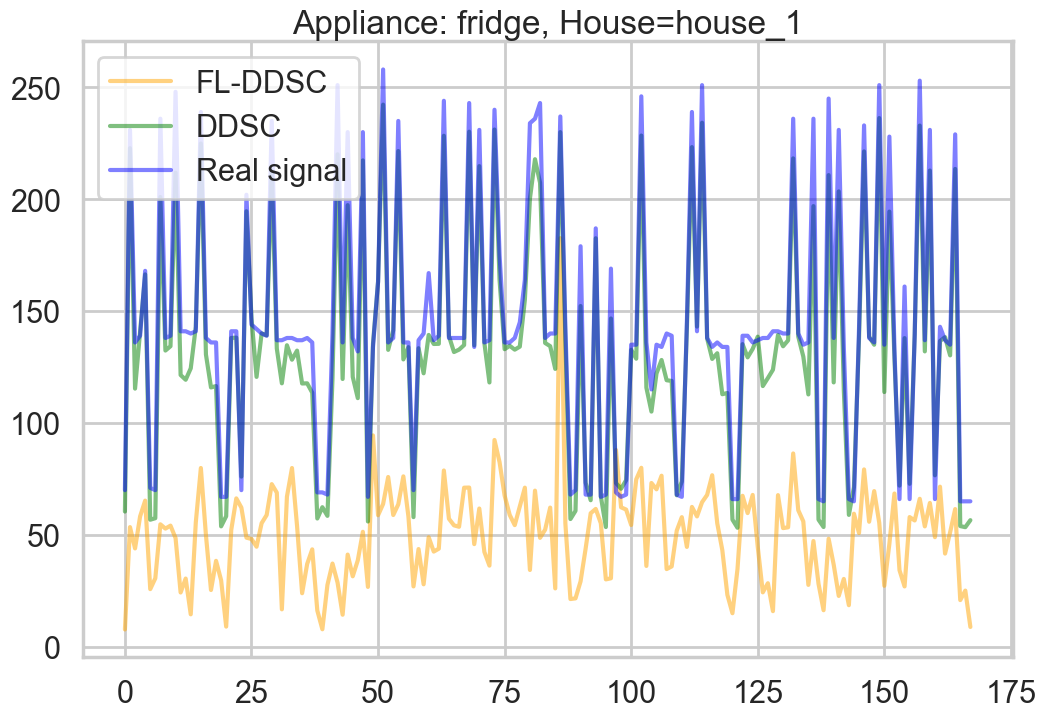

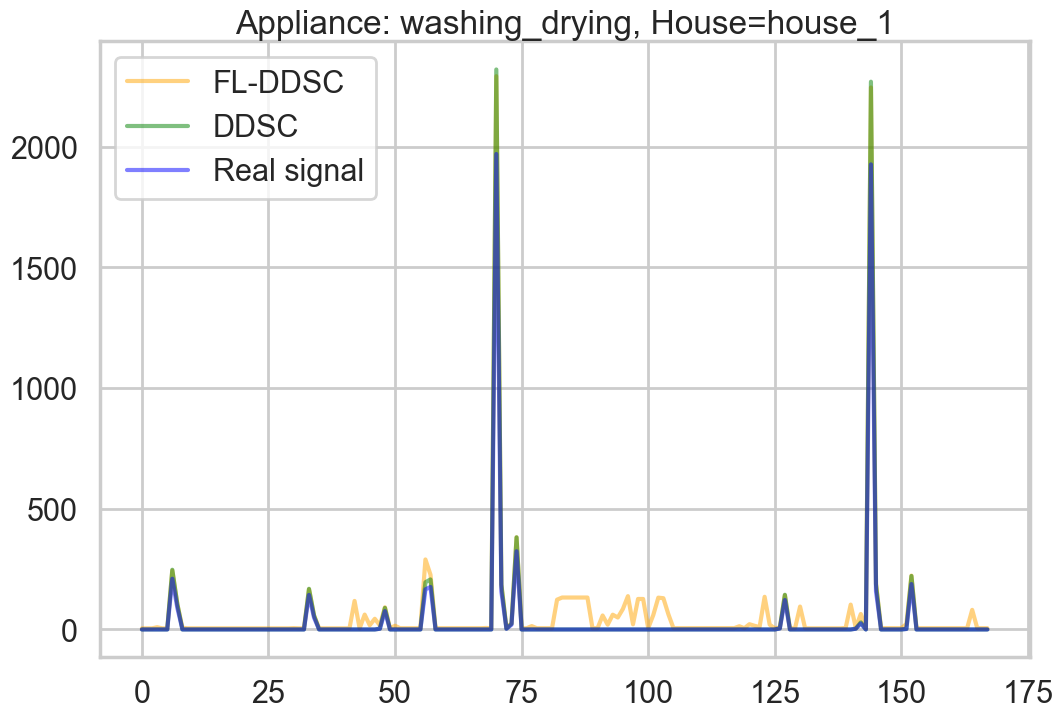

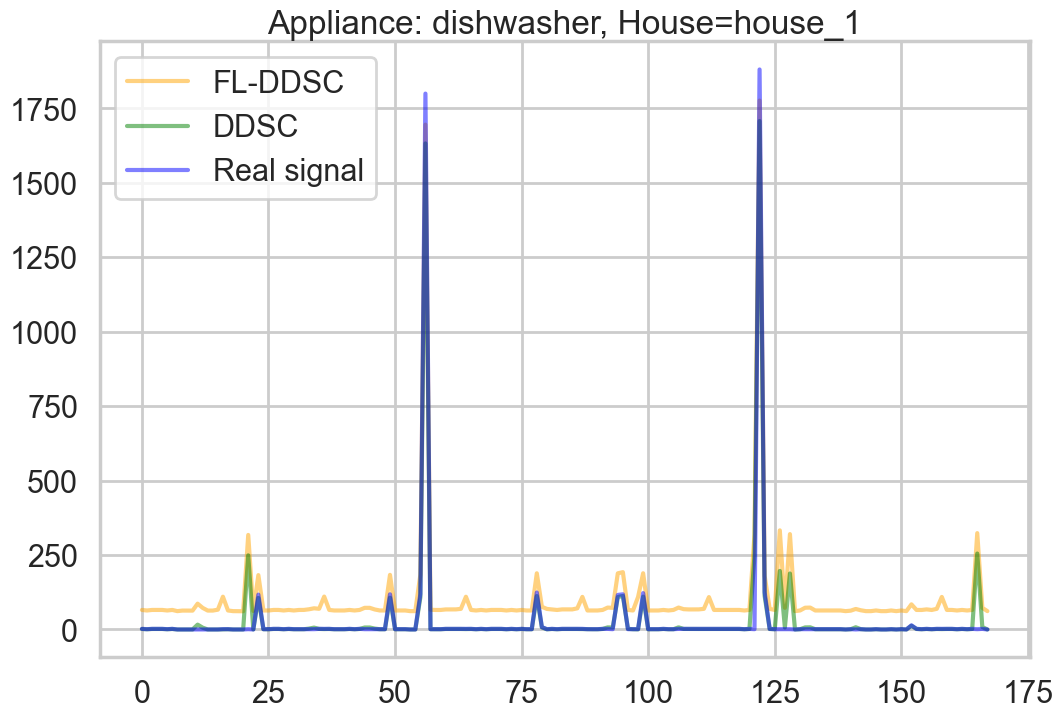

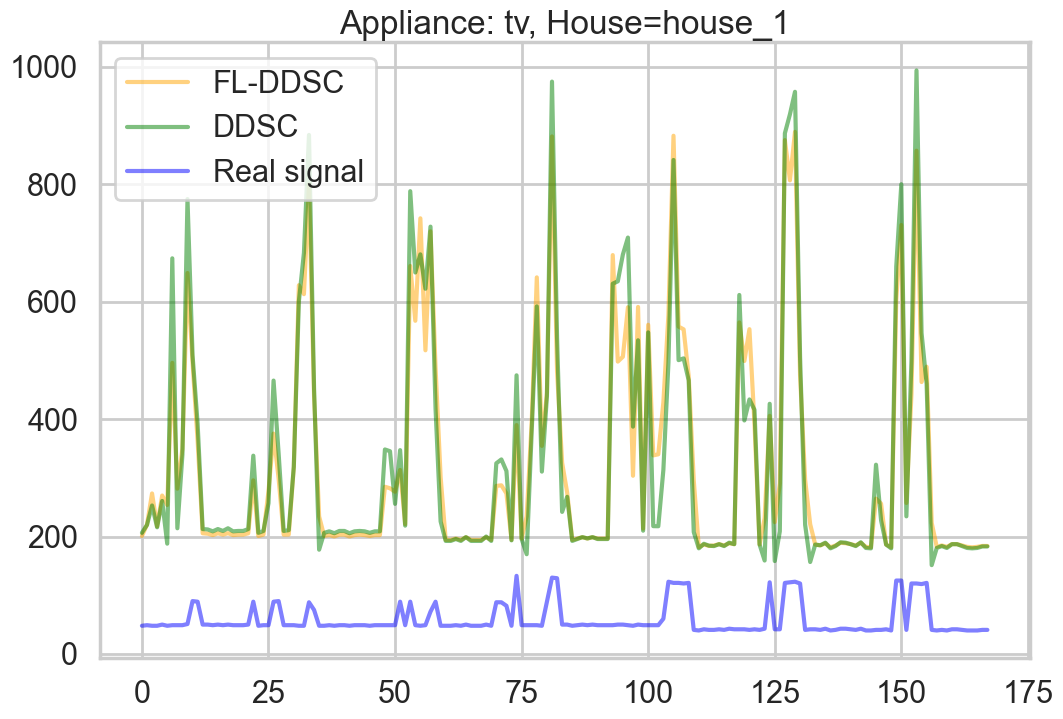

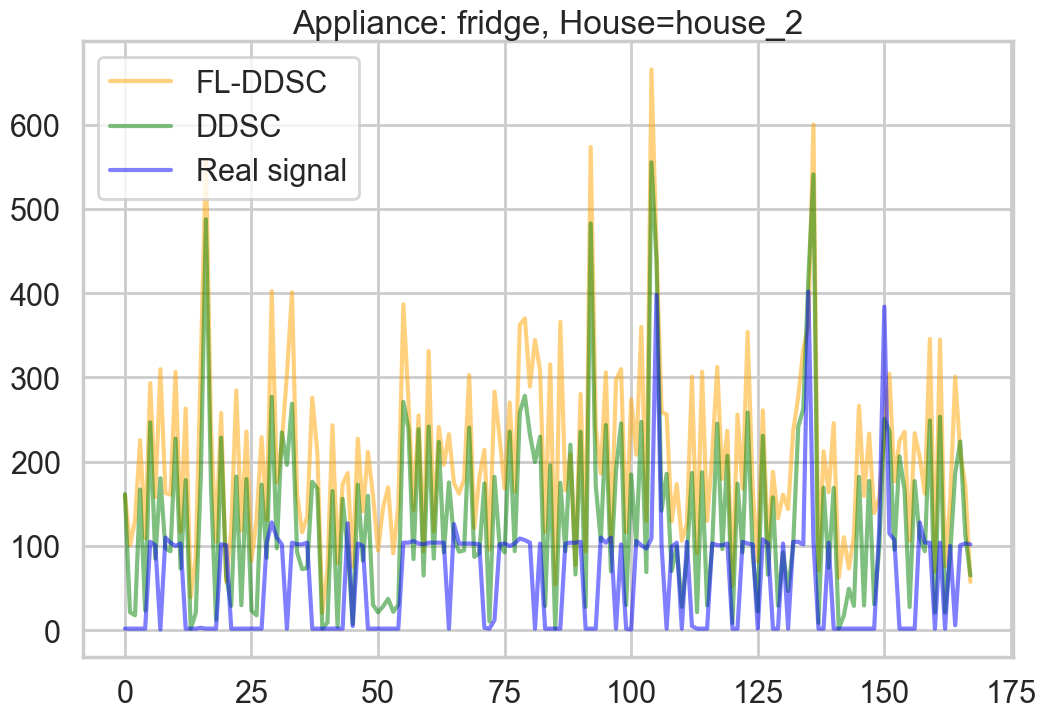

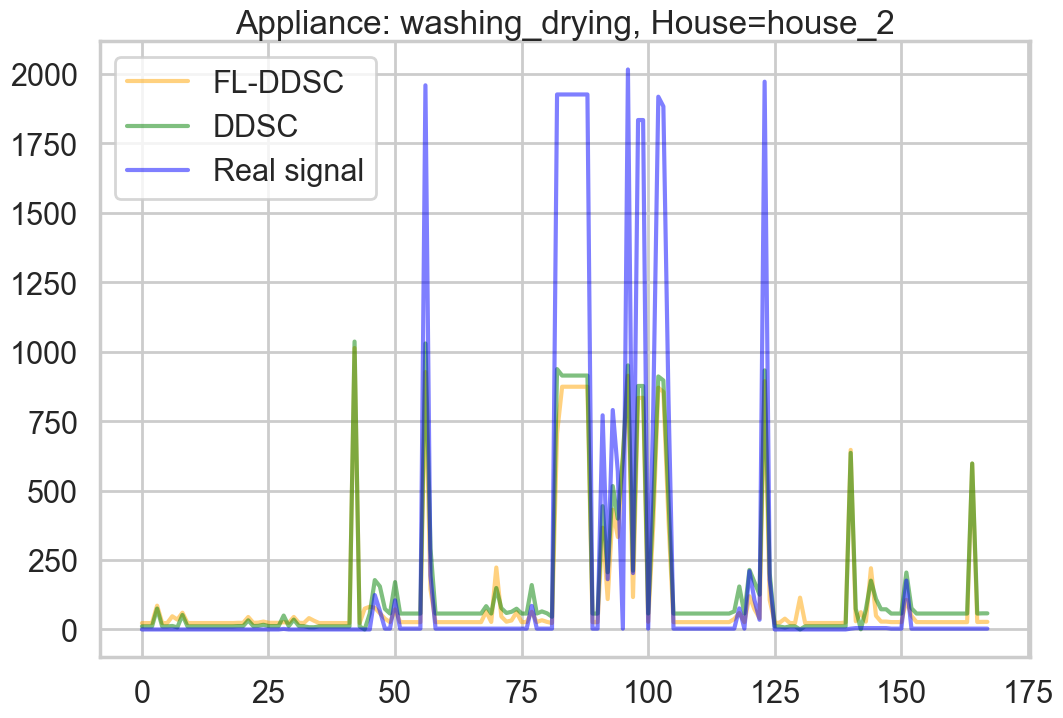

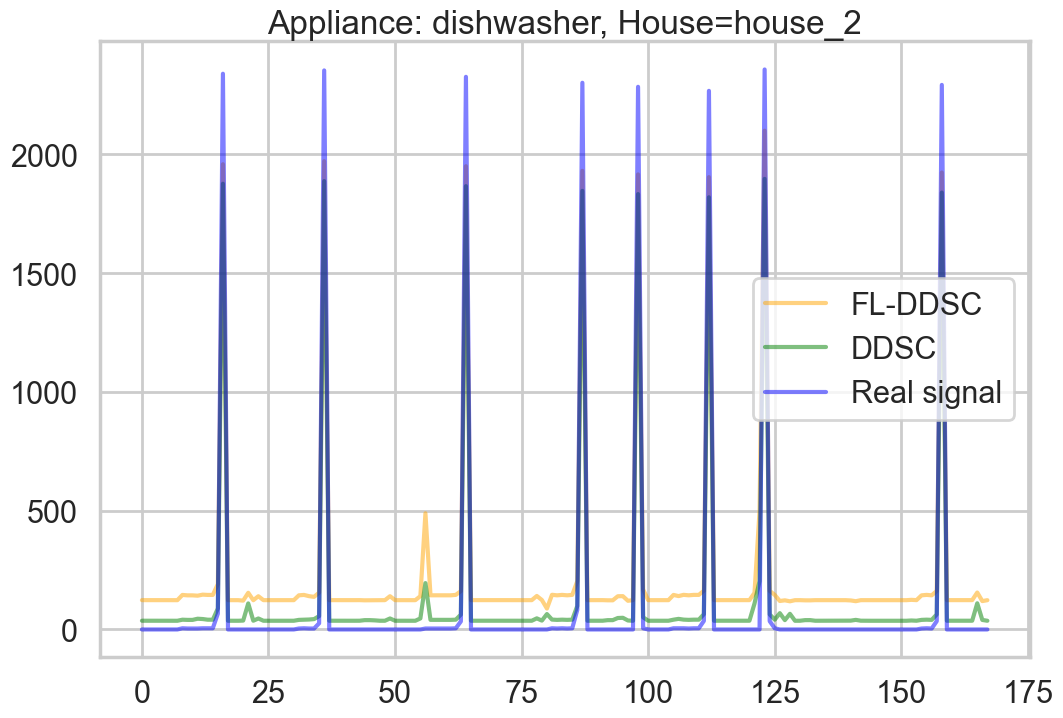

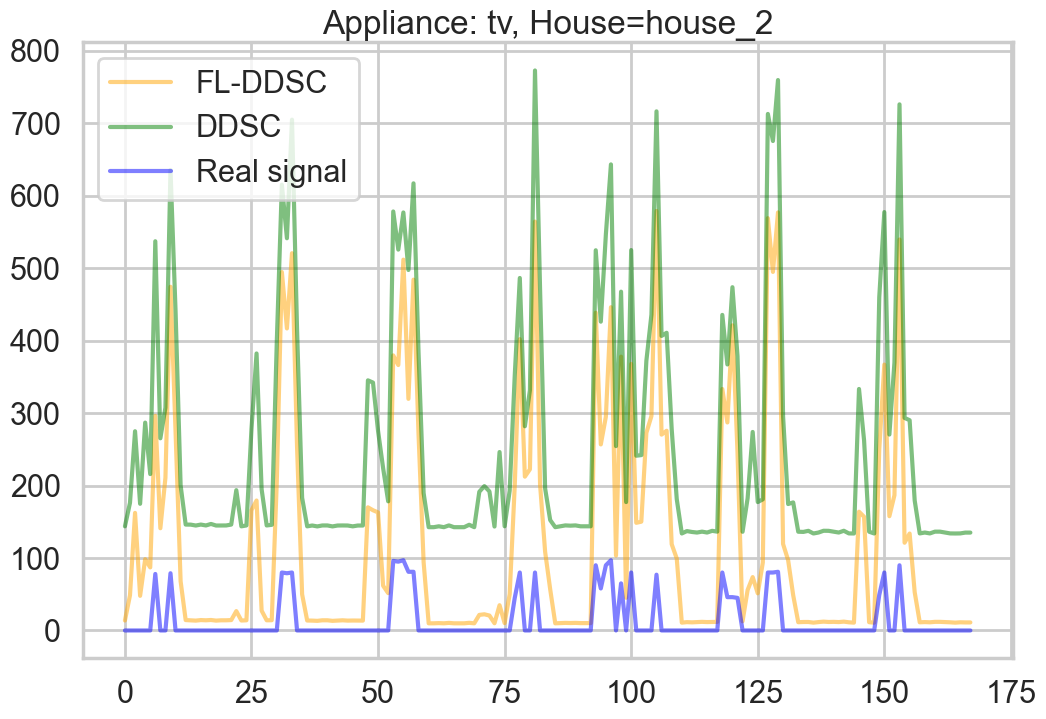

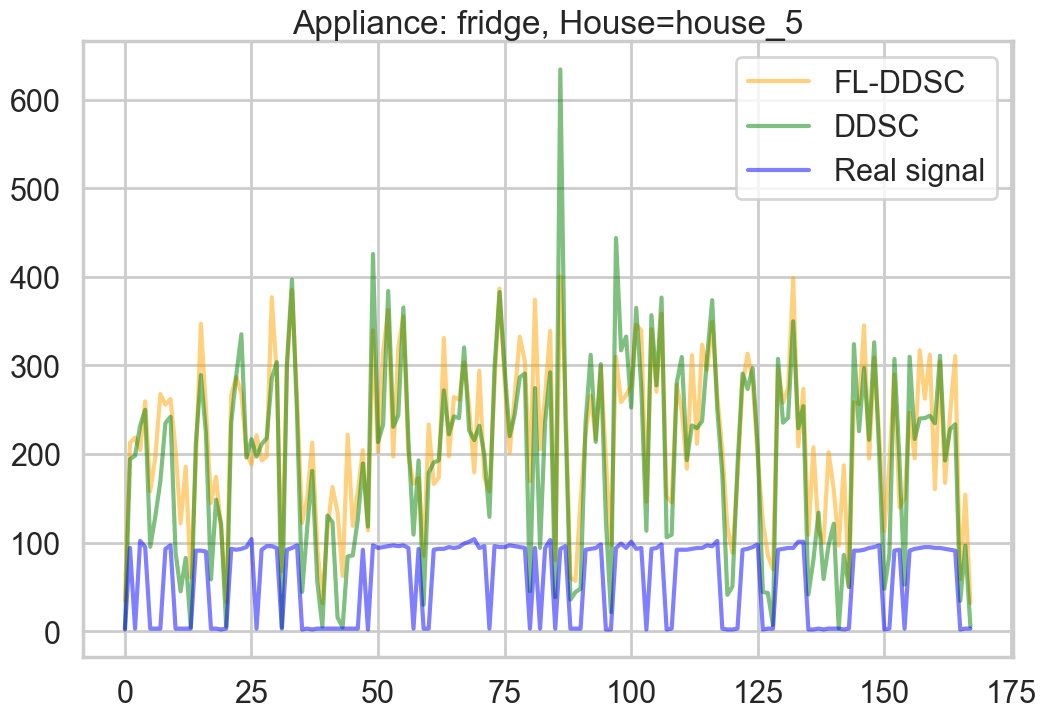

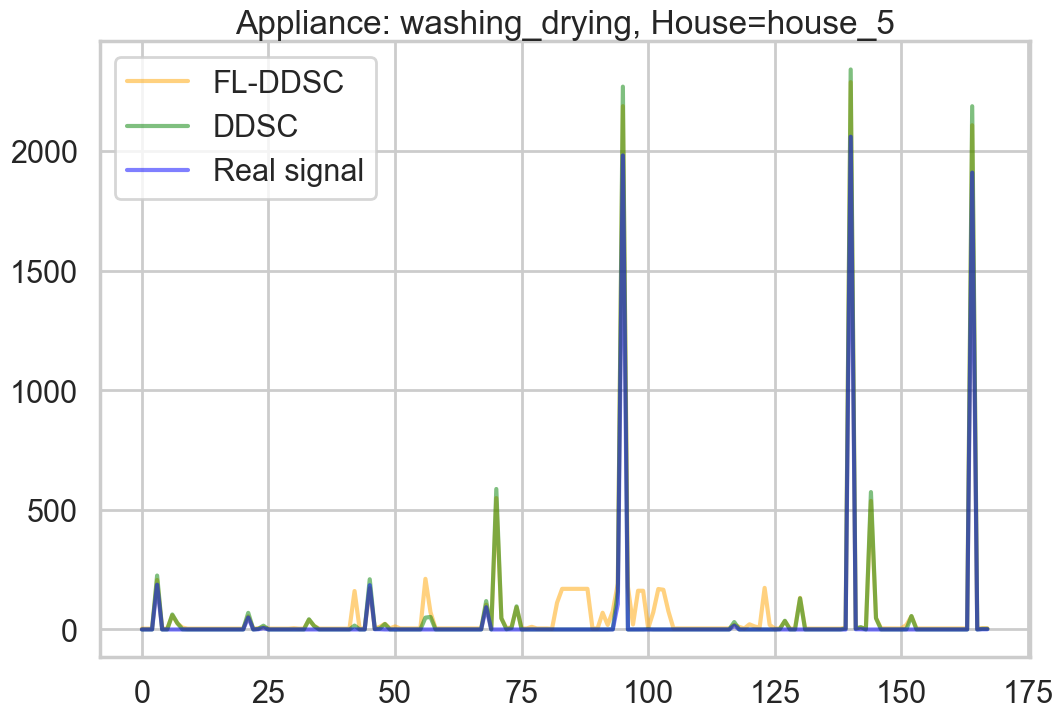

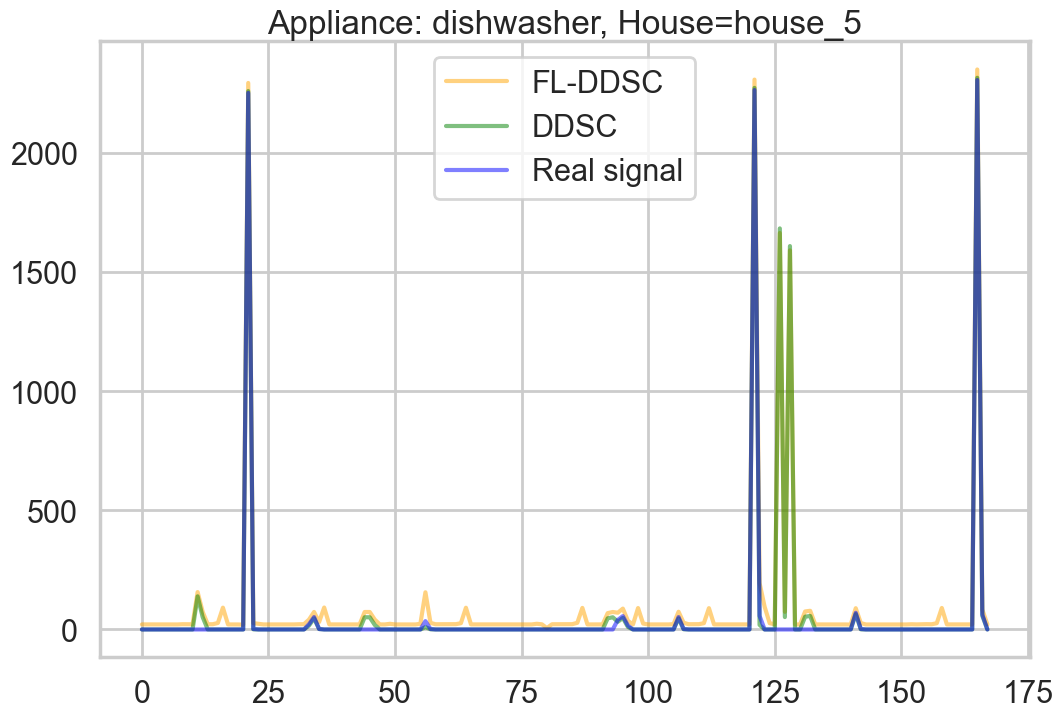

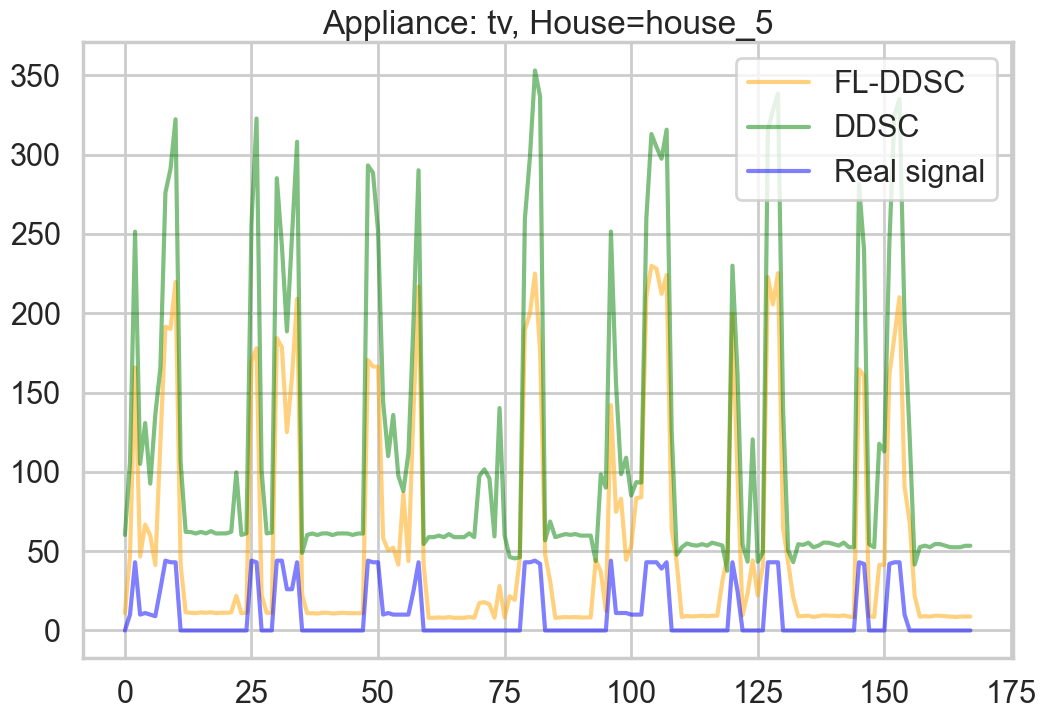

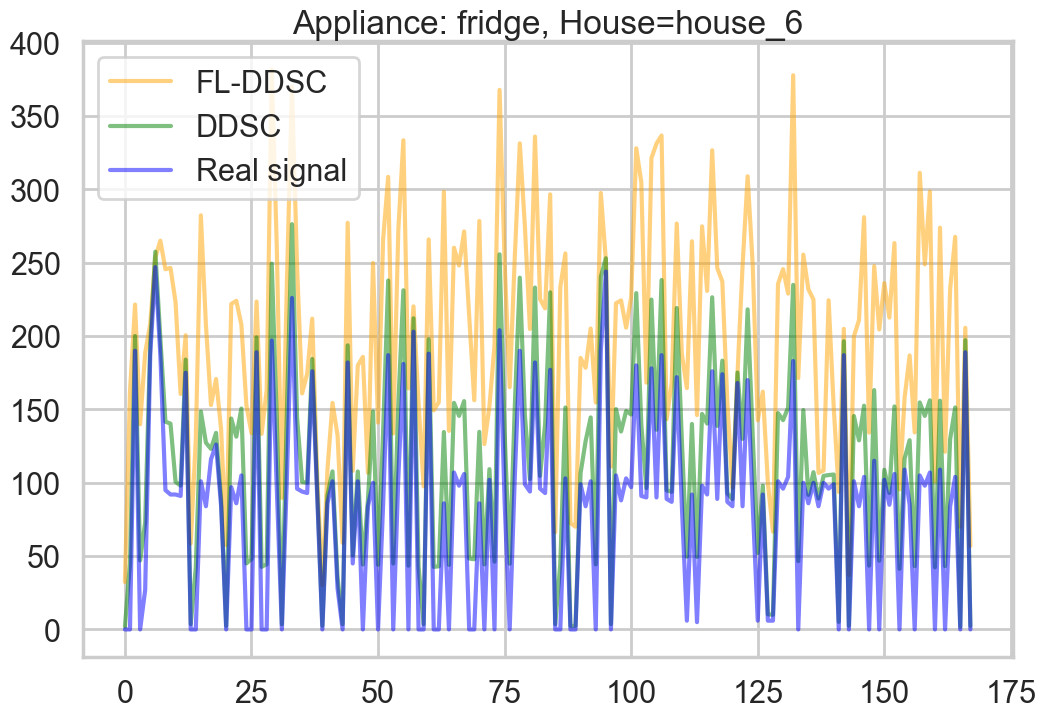

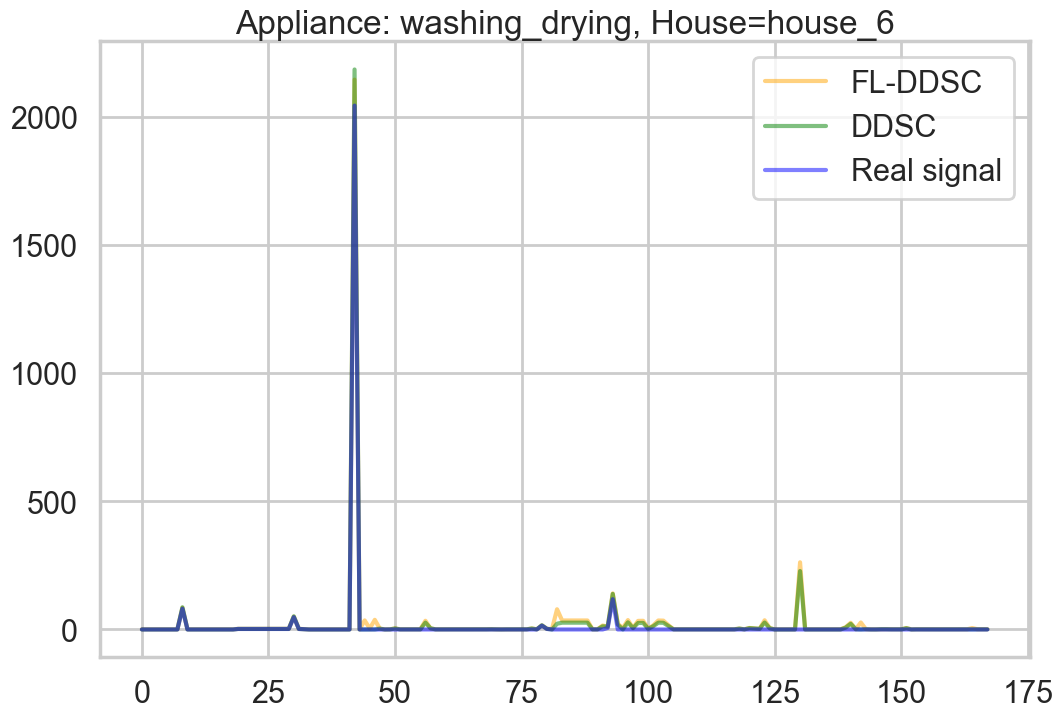

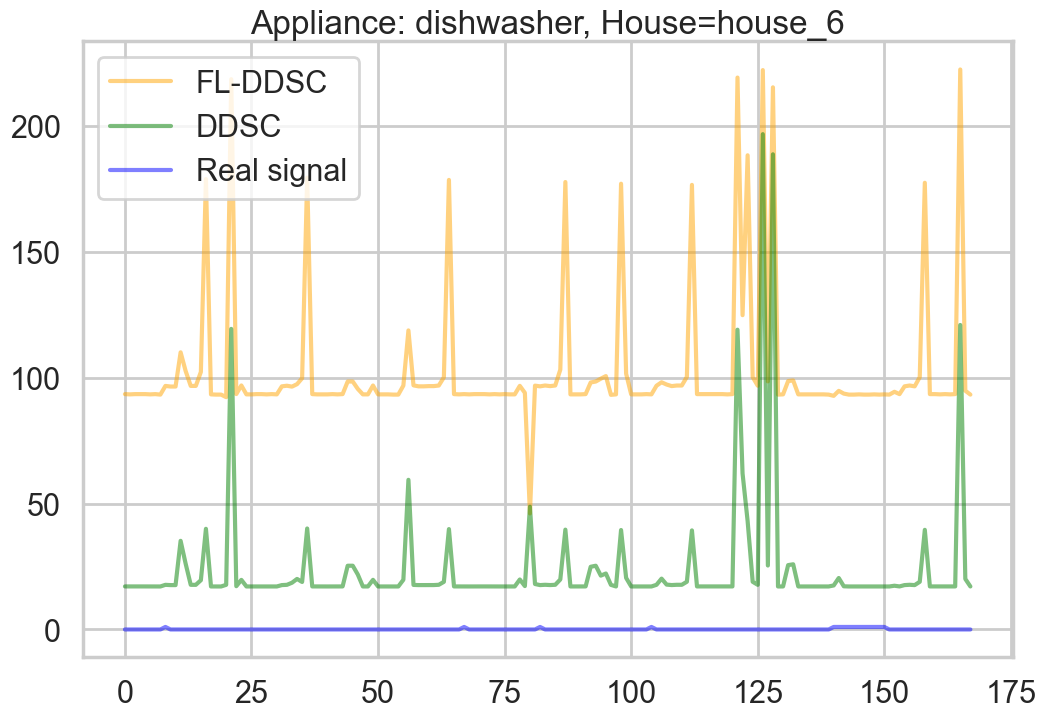

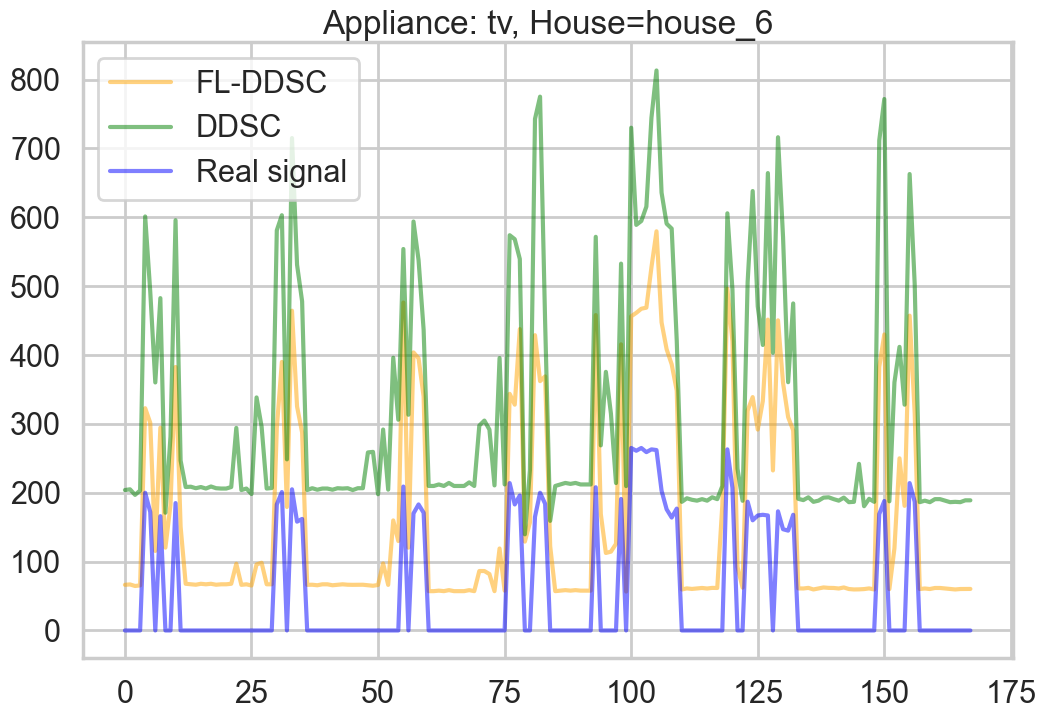

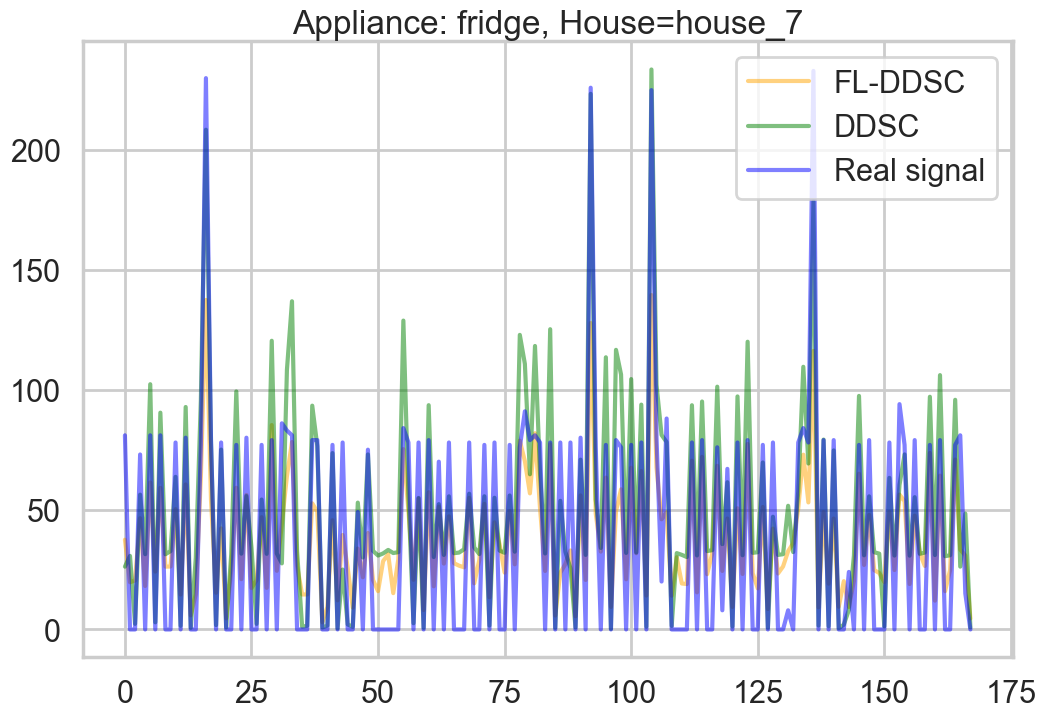

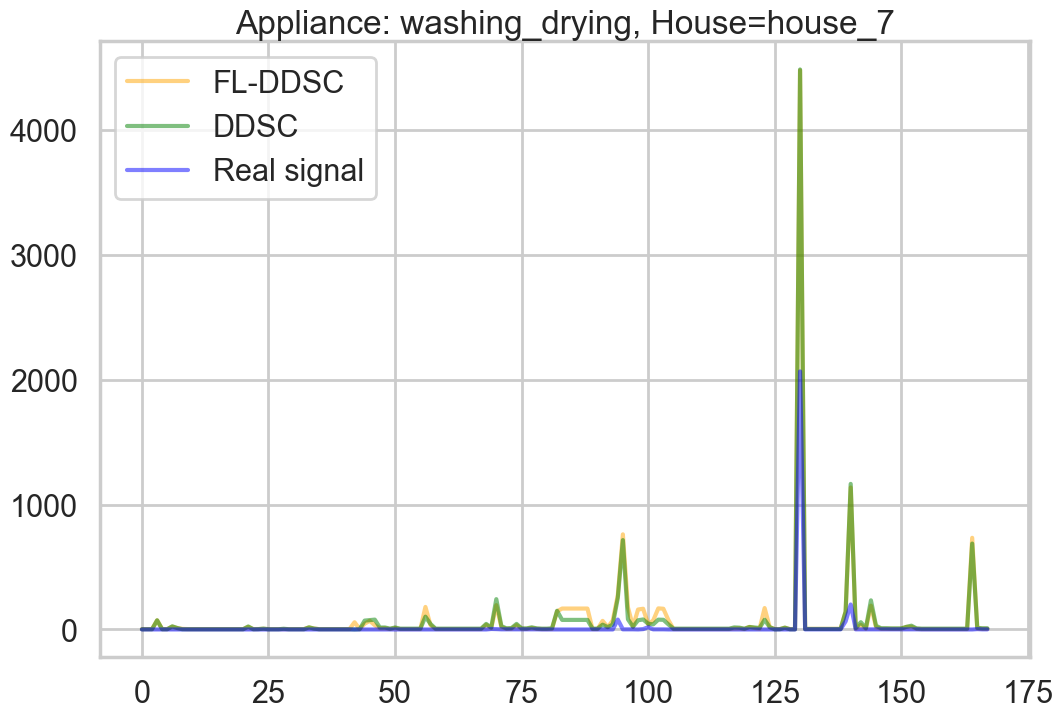

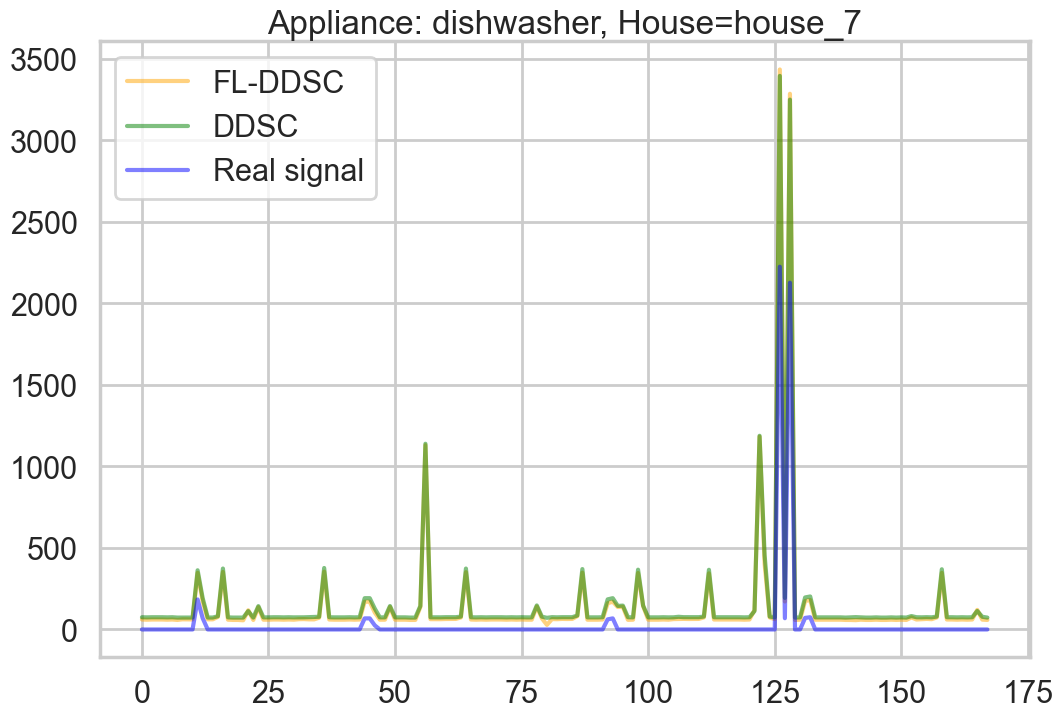

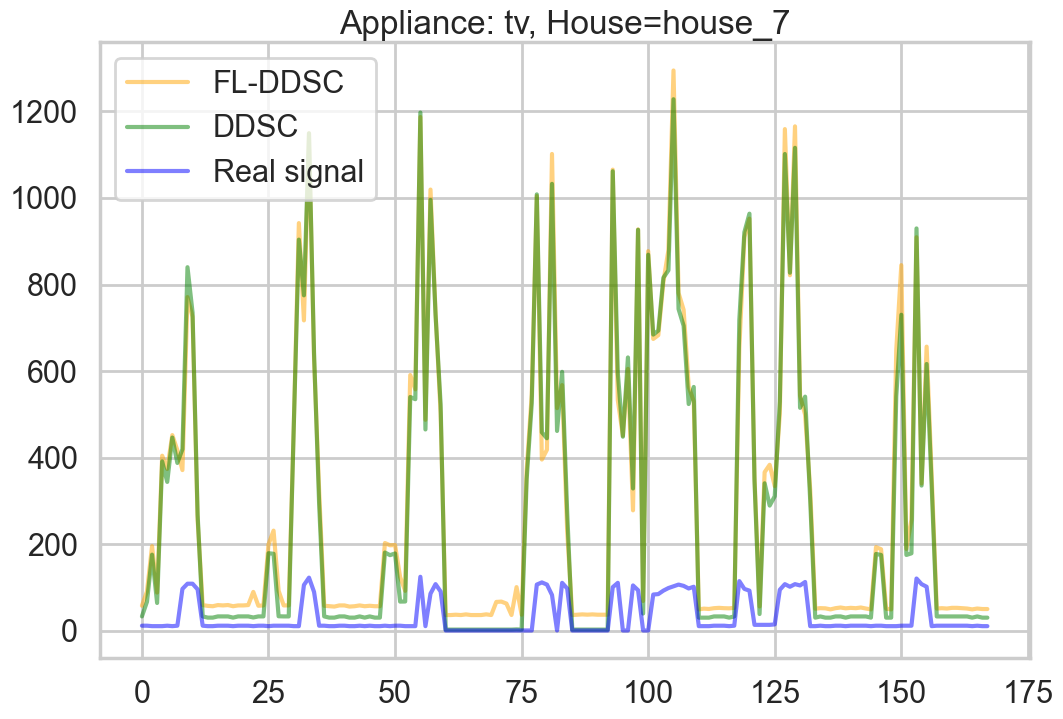

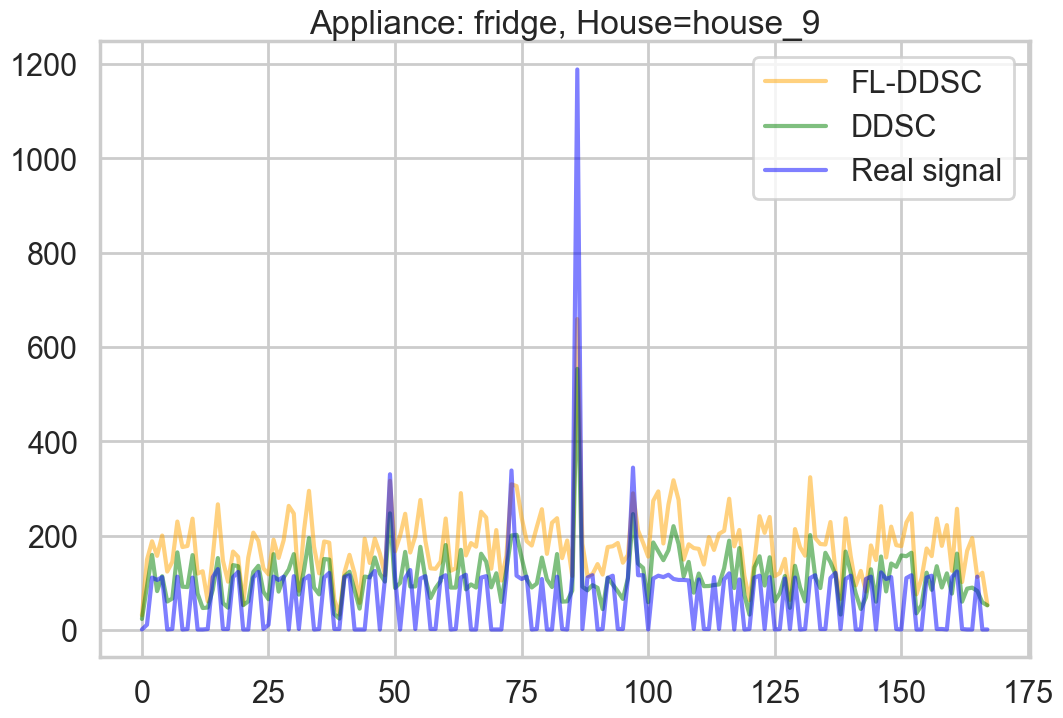

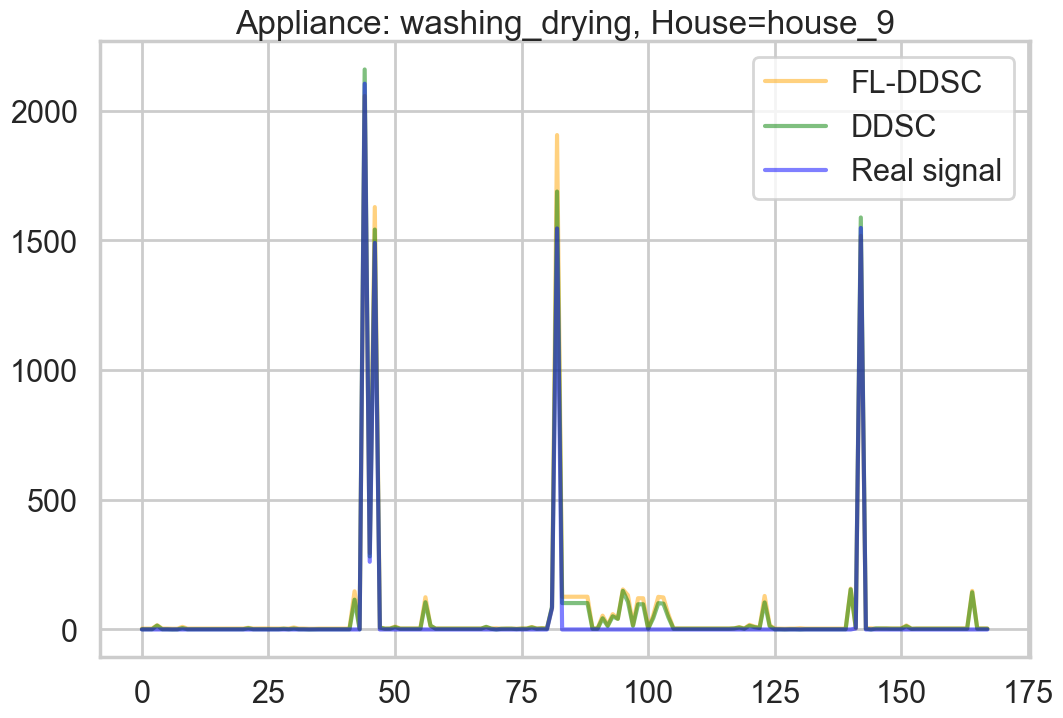

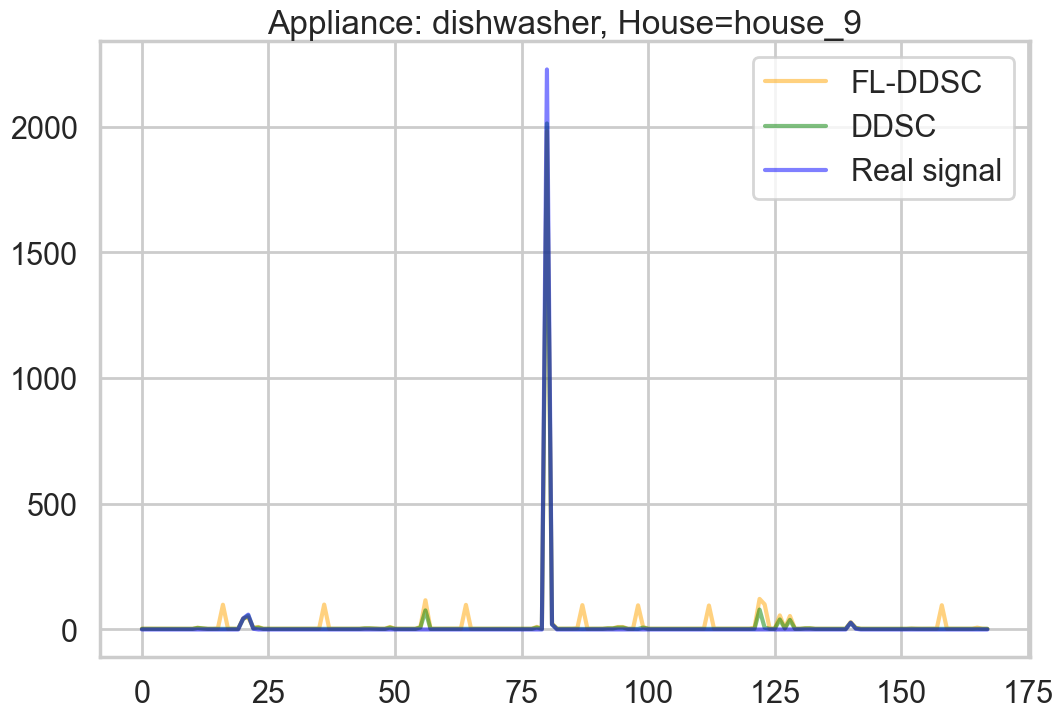

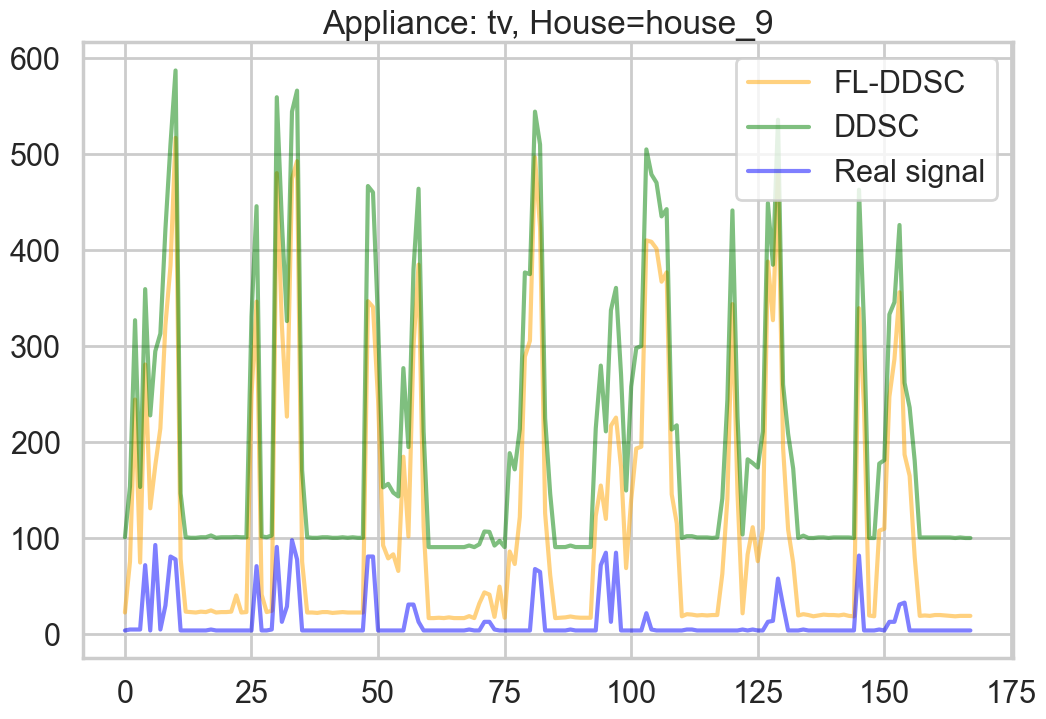

In [440]:
plot_all_plots(
    fl_data=list(fedavg_refit_only.clients_data.items()),
    reg_data=all_house_train,
    Bs_reg=Bs_reg_refit_only[0],
    As_reg=As_reg_refit_only[0],
    fedavg=fedavg_refit_only,
    data_type='train',
)



0

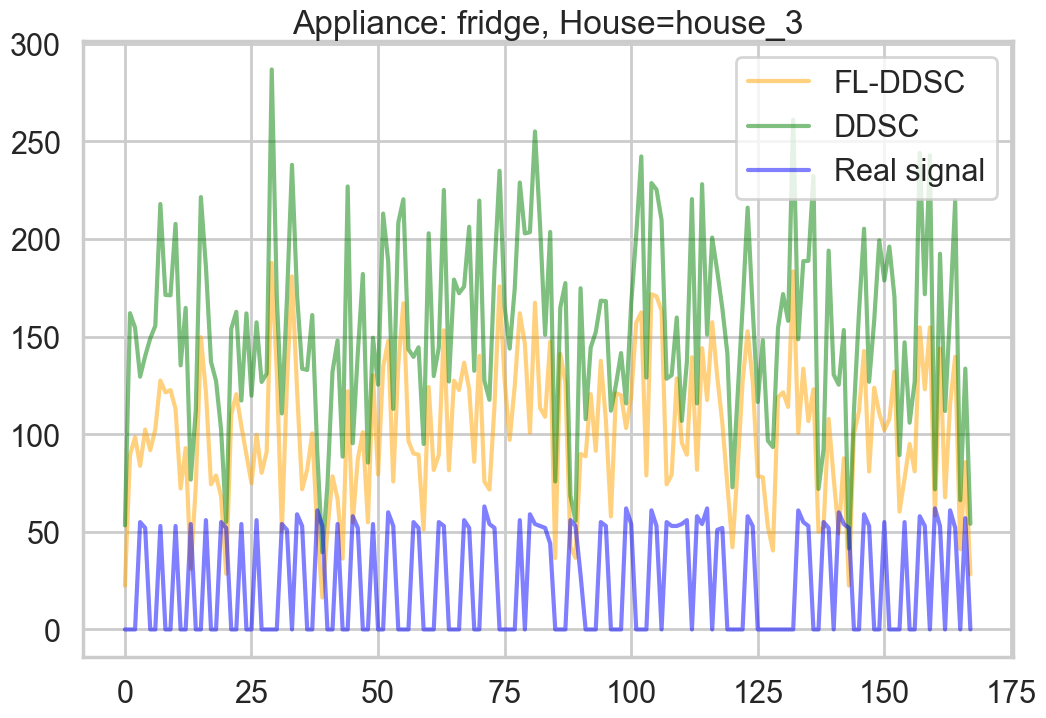

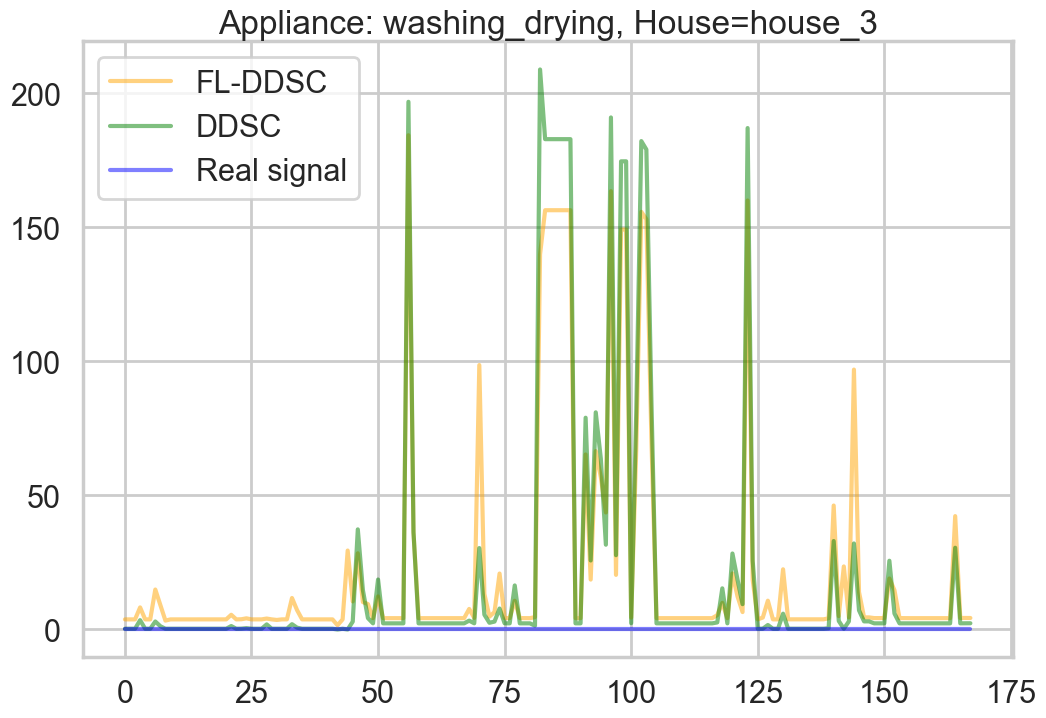

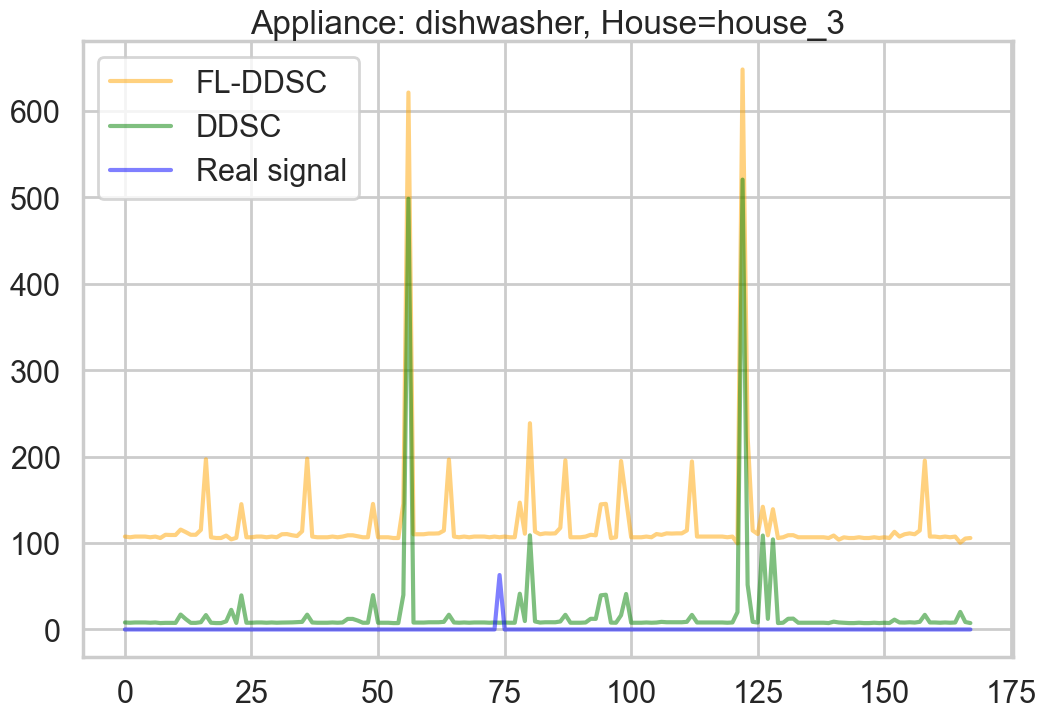

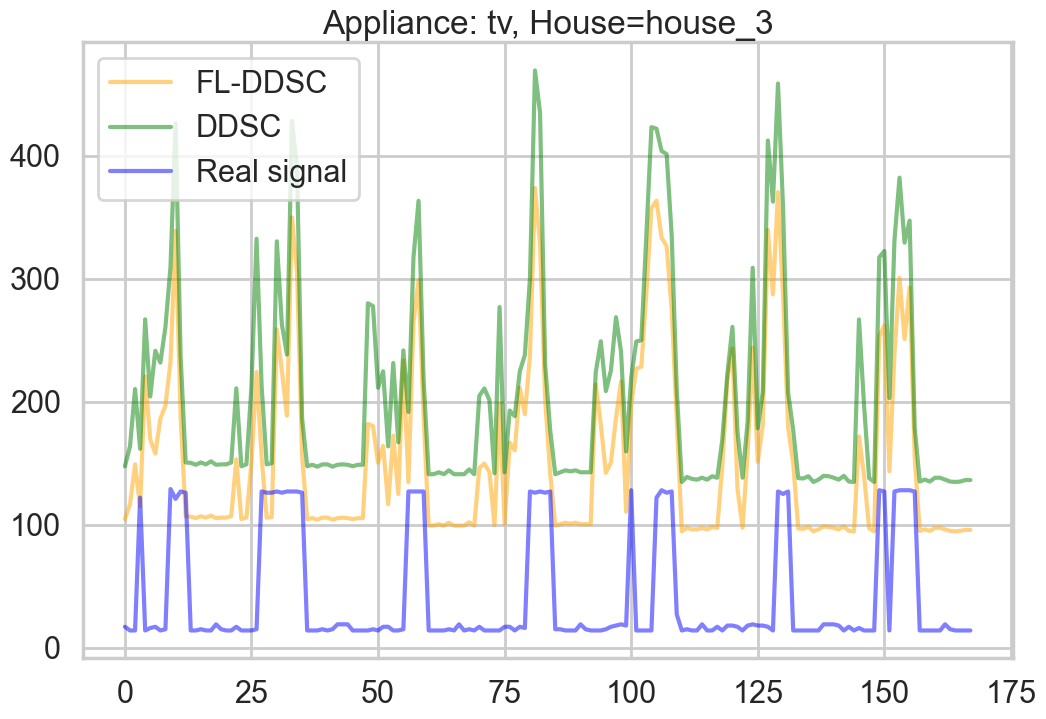

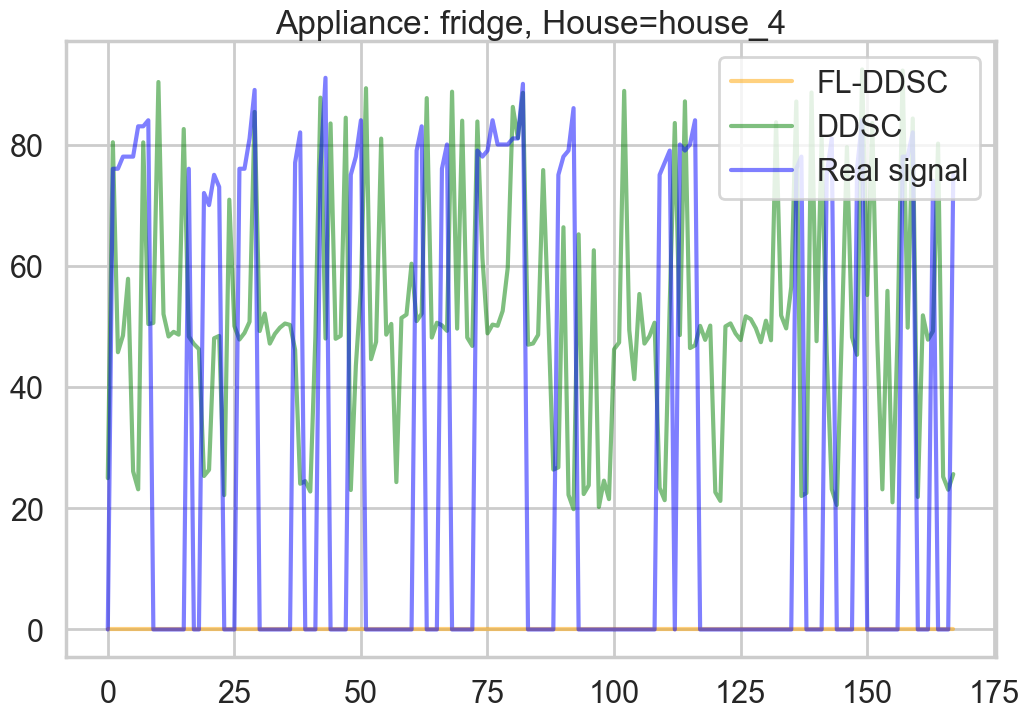

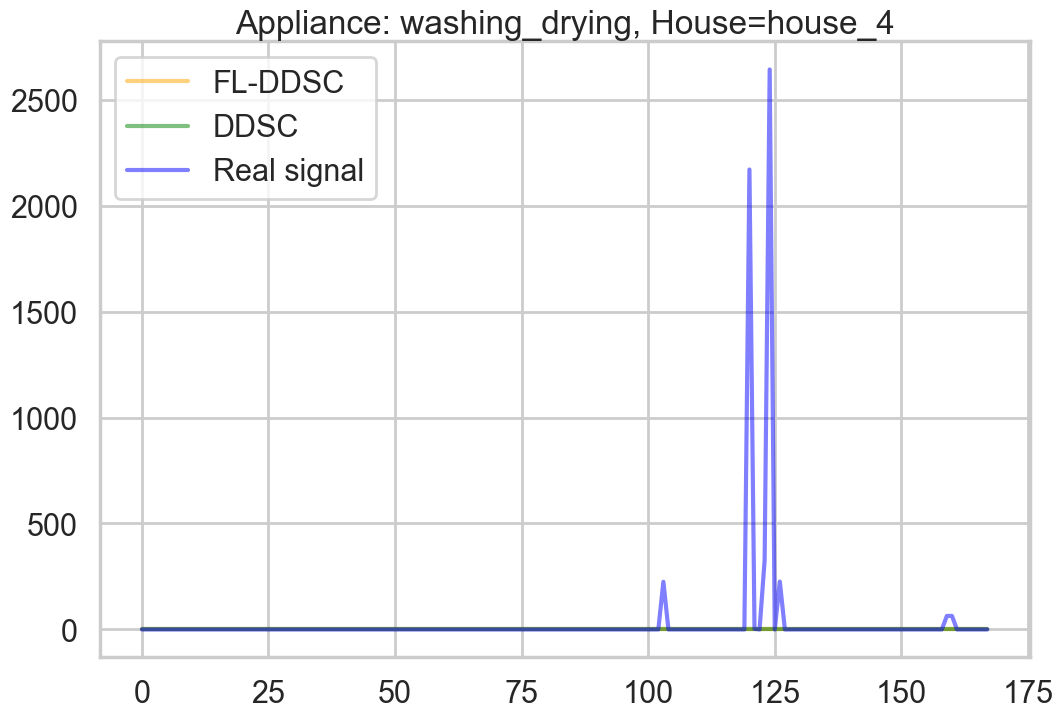

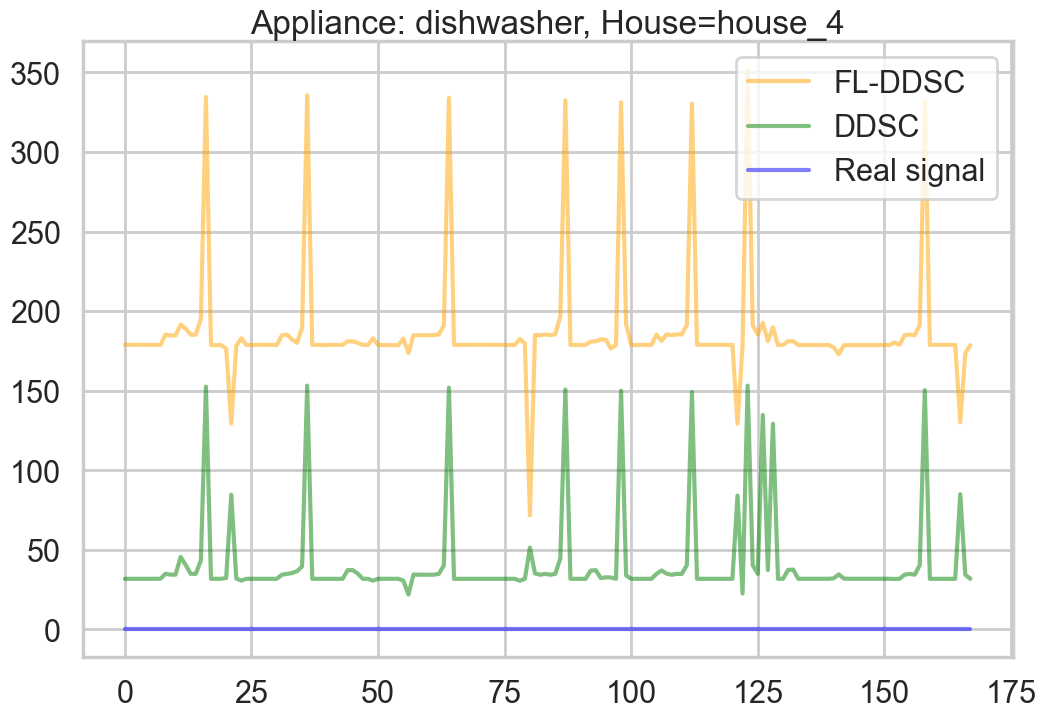

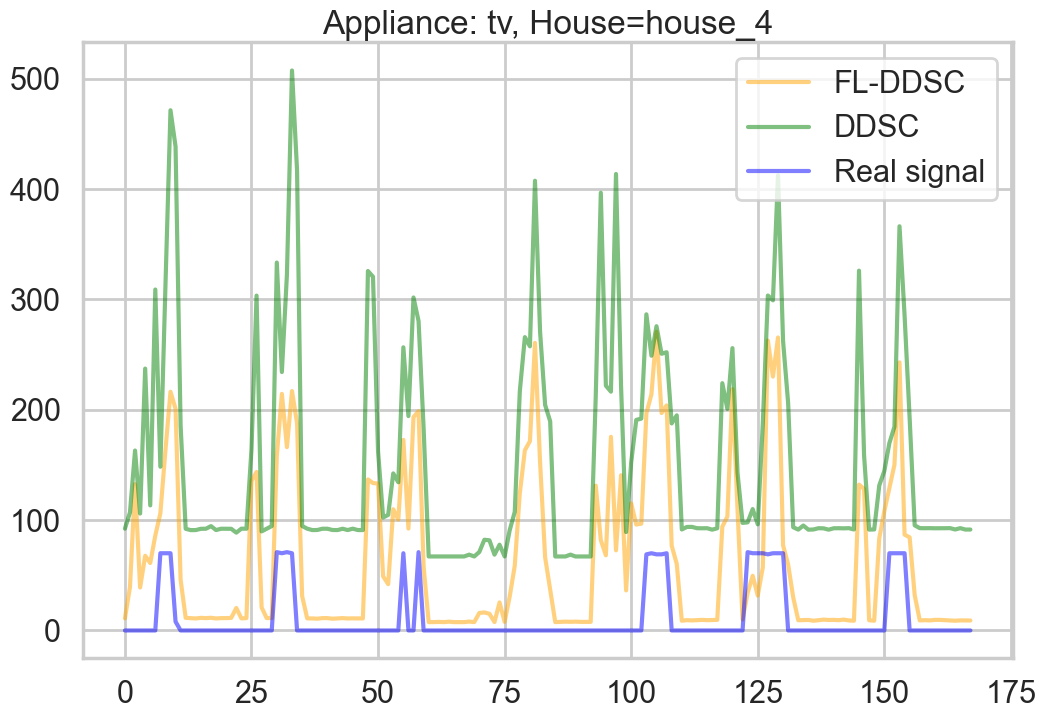

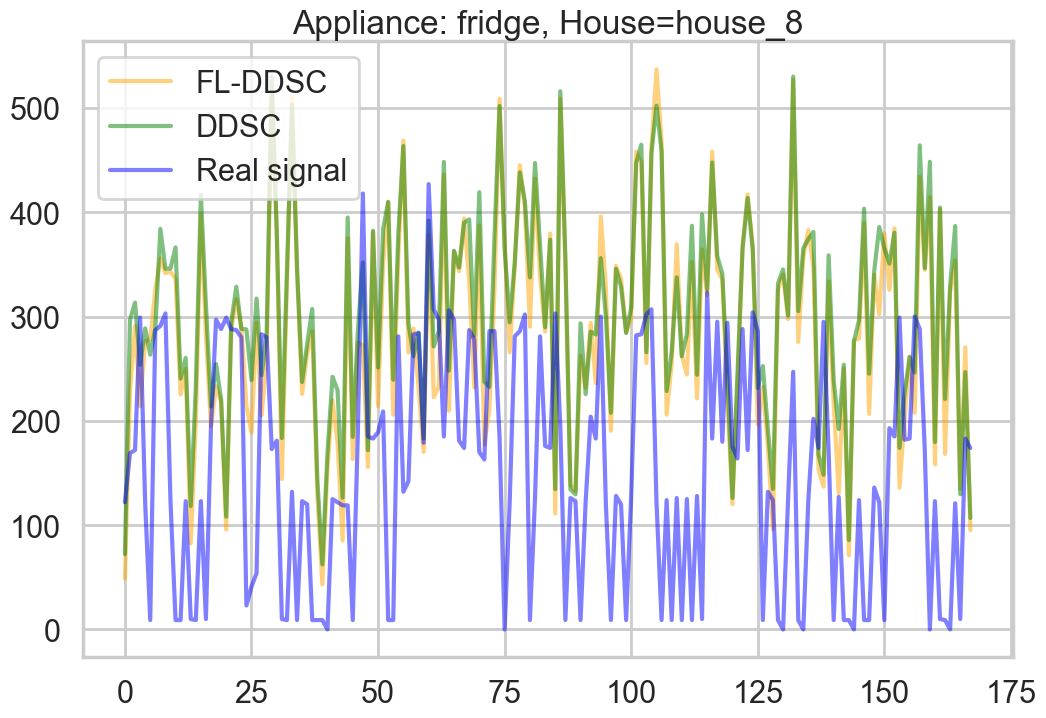

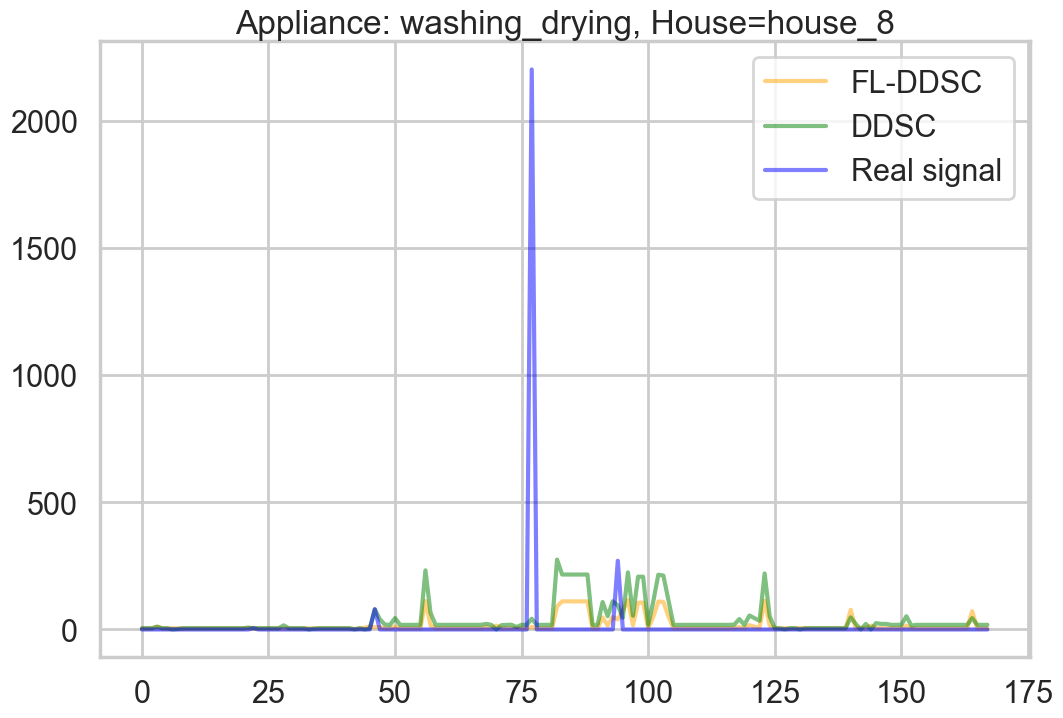

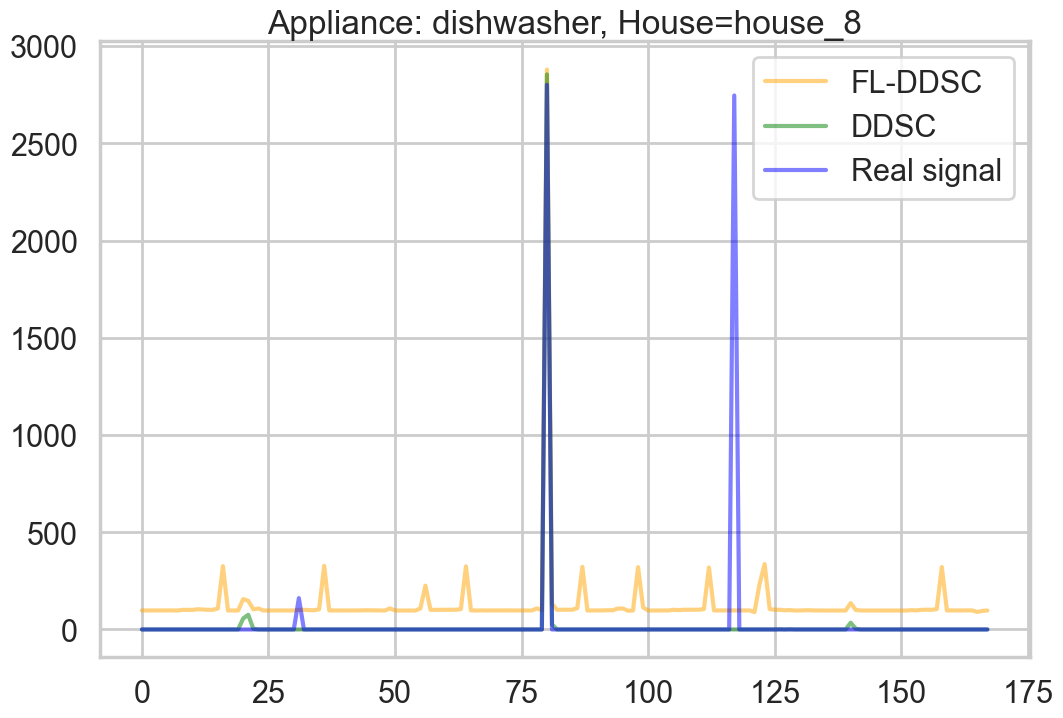

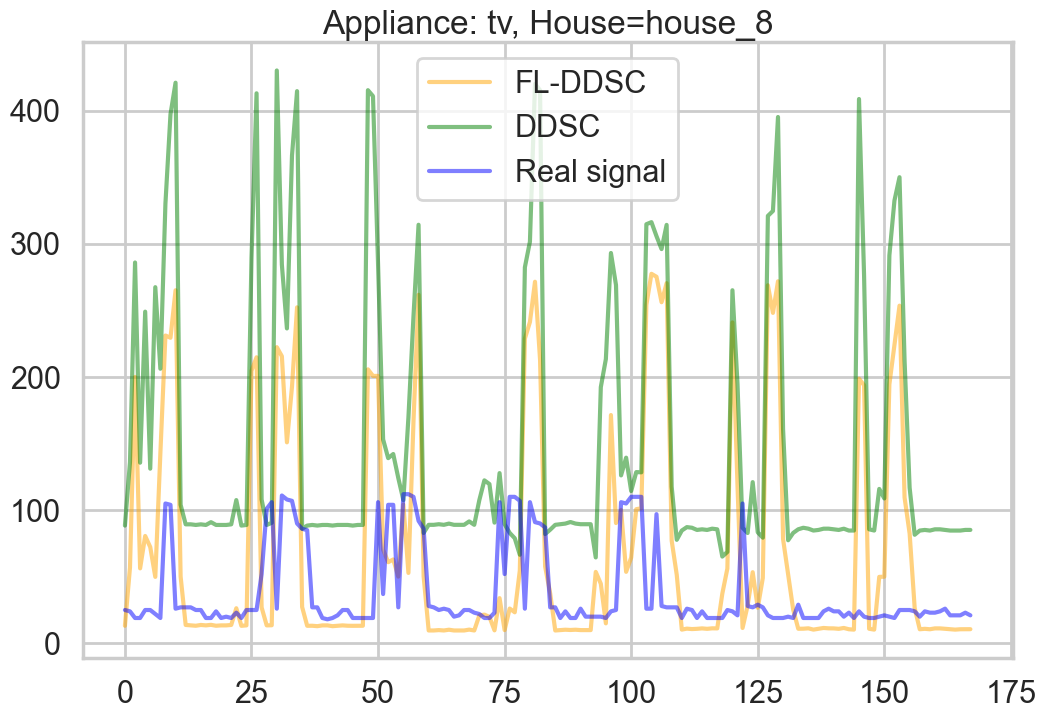

In [441]:
plot_all_plots(
    fl_data=list(fedavg_refit_only.test_data.items()),
    reg_data=all_house_test,
    Bs_reg=Bs_reg_refit_only[0],
    As_reg=None,
    fedavg=fedavg_refit_only,
    data_type='test',
)



In [442]:
appliance_index = 0
house_index = 0

In [443]:
list(fedavg_refit_only.clients_data.keys())

['house_1', 'house_2', 'house_5', 'house_6', 'house_7', 'house_9']

## Train plots

In [444]:
house, house_data = list(fedavg_refit_only.clients_data.items())[house_index]
A_train_reg_refit_only = dsc.F_obj(x=all_house_train['aggregate'].values, B=Bs_reg_refit_only[0], A=As_reg_refit_only[0], rp_gl=dsc.rp)
A_no_init = dsc.F_obj(x=all_house_train['aggregate'].values, B=Bs_reg_refit_only[0], rp_gl=dsc.rp)

#plot_house_appliance_consumption(house_data, house_index, house, appliance_index, fedavg_refit_only, A_train_reg_refit_only, Bs_reg_refit_only[0])



## Test plots

In [445]:
house, house_data = list(fedavg_refit_only.test_data.items())[house_index]
#plot_house_appliance_consumption(house_data, house_index, house, appliance_index, fedavg_refit_only, A_test_reg_refit_only, Bs_reg_refit_only[0])



## How well is DDSC performing inside a client (tests whether DDSC is working well or not)

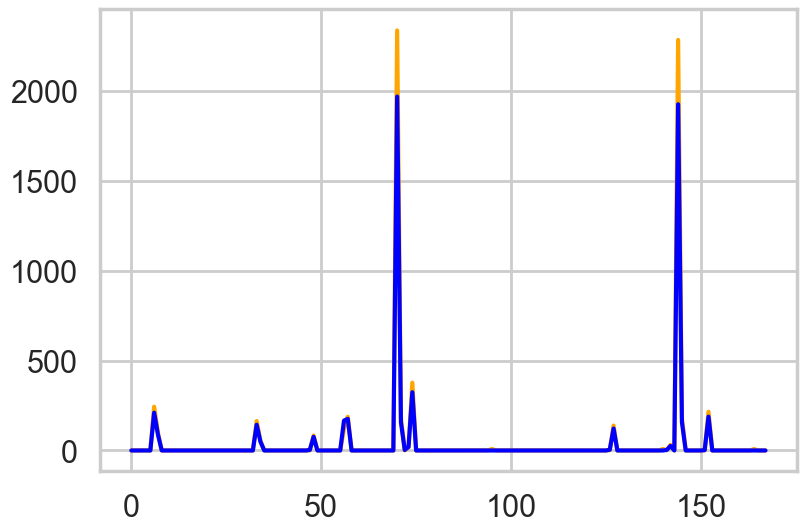

In [446]:
house_index = 0
appliance_index = 1

house, house_data = list(fedavg_refit_only.clients_data.items())[house_index]
B_house = fedavg_refit_only.Bs_from_houses[house_index]
A_house_fl = fedavg_refit_only.dsc.F_obj(x=house_data['aggregate'].values, B=np.hstack(B_house.values()), rp_gl=dsc.rp)

A_cat = A_house_fl[nnsc_params['n_components']*appliance_index:nnsc_params['n_components']*(appliance_index + 1),:]
y_house_fl = np.dot(B_house[appliance_categories[appliance_index]], A_cat)

plt.figure(figsize=(9, 6))
plt.plot(y_house_fl, color='orange', label='FL-DDSC')
plt.plot(house_data[appliance_categories[appliance_index]].values, color='blue', label='Real')


# Train on REFIT, test on REDD (Domain shift)

In [447]:
method = 'REFIT train, REDD test'
train, test = split_data(data, method)

### Regular DDSC

In [452]:
appliance_categories = ['fridge', 'washing_drying']

all_house_train = repackage_data(train, appliance_categories + ['aggregate'])
all_house_test = repackage_data(test, appliance_categories + ['aggregate'])

In [453]:
Bs_reg_refit_to_redd, dsc, B_list, As_reg_refit_to_redd = train_regular_DDSC_on_all_houses(
            all_house_train,
            general_params,
            nnsc_params,
            dd_params,
            transfer_params,
            appliance_categories
)

fridge
washing_drying
done DD


In [454]:
A_test_reg_refit_to_redd = dsc.F_obj(x=all_house_test['aggregate'].values,
                                     B=np.hstack(Bs_reg_refit_to_redd),
                                     rp_gl=dsc.rp
                                    )
acc_ref_refit_to_redd = dd_acc_cat_regular_sc(A_test_reg_refit_to_redd,
                            np.hstack(Bs_reg_refit_to_redd),
                            all_house_test,
                            appliance_categories,
                            n_components
                           )

print('Average Disaggregation Accuracy is', acc_ref_refit_to_redd[1])

Average Disaggregation Accuracy is 0.586


In [455]:
rmse_ref_refit_to_redd = nrmse_per_category_regular_sc(A_test_reg_refit_to_redd,
                                                       np.hstack(Bs_reg_refit_to_redd),
                                                       all_house_test,
                                                       appliance_categories,
                                                       n_components
                                                      )

for category in appliance_categories:
    print(category)
    print('    Average RMSE is', rmse_ref_refit_to_redd[category][0])
    print('    Average NRMSE is', rmse_ref_refit_to_redd[category][1])
    print('\n')

fridge
    Average RMSE is 257.4695311744506
    Average NRMSE is 0.137964942573034


washing_drying
    Average RMSE is 65.97720042626447
    Average NRMSE is 0.06292876428979698




### FL + DDSC

In [456]:
fedavg_refit_to_redd = FedAvgDDSC(
    train,
    test,
    general_params,
    nnsc_params,
    dd_params,
    appliance_categories,
)

fedavg_refit_to_redd.run_fed_avg()

sending to  house_1
sending to  house_2
sending to  house_3
sending to  house_4
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_8
sending to  house_9
current B variation for fridge is 88.45950696526707
current B variation for washing_drying is 88.46055374680685
sending to  house_1
sending to  house_2
sending to  house_3
sending to  house_4
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_8
sending to  house_9
current B variation for fridge is 0.03948593017878058
current B variation for washing_drying is 0.2594375792421912
sending to  house_1
sending to  house_2
sending to  house_3
sending to  house_4
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_8
sending to  house_9
current B variation for fridge is 0.03744164091950546
current B variation for washing_drying is 0.20085320579792368
sending to  house_1
sending to  house_2
sending to  house_3
sending to  house_4
sending to  house_5
sending to  house

{'fridge': array([[0.00333343, 0.0029774 , 0.00311863, ..., 0.00317429, 0.00418296,
         0.00316472],
        [0.00385414, 0.00353786, 0.00352016, ..., 0.00388293, 0.00355806,
         0.00356979],
        [0.00210506, 0.00262179, 0.0022753 , ..., 0.00264712, 0.00228721,
         0.00242323],
        ...,
        [0.00186533, 0.00262797, 0.00100253, ..., 0.00221569, 0.00207752,
         0.00119982],
        [0.00263446, 0.00269258, 0.00273578, ..., 0.00233919, 0.00195817,
         0.0029818 ],
        [0.00266438, 0.00349874, 0.00194553, ..., 0.00331742, 0.0030836 ,
         0.00211053]]),
 'washing_drying': array([[1.71446325e-04, 2.56118235e-04, 4.28169232e-05, ...,
         3.06223382e-04, 8.56451232e-04, 1.86595797e-04],
        [1.71446325e-04, 2.56118235e-04, 4.28169232e-05, ...,
         3.06223382e-04, 8.56451232e-04, 1.86595797e-04],
        [1.71446325e-04, 2.56118235e-04, 4.28169232e-05, ...,
         3.06223382e-04, 8.56451232e-04, 1.86595797e-04],
        ...,
        

In [457]:
acc_fl_refit_to_redd = []
for house, house_data in fedavg_refit_to_redd.test_data.items():
    A_test = fedavg_refit_to_redd.dsc.F_obj(x=house_data['aggregate'].values,
                                            B=np.hstack(list(fedavg_refit_to_redd.B_t.values())),
                                            rp_gl=fedavg_refit_to_redd.dsc.rp
                                           )
    acc_fl_refit_to_redd.append(dd_acc_cat(A_test,
                          np.hstack(list(fedavg_refit_to_redd.B_t.values())),
                          house_data,
                          fedavg_refit_to_redd.appliance_categories,
                          fedavg_refit_to_redd.nnsc_params['n_components']
                         )
              )

print('Average Disaggregation Accuracy is', np.round(np.mean([x[1] for x in acc_fl_refit_to_redd]), 4))

Average Disaggregation Accuracy is 0.582


In [458]:
rmse_fl_refit_to_redd = []
for house, house_data in fedavg_refit_to_redd.test_data.items():
    A_test = fedavg_refit_to_redd.dsc.F_obj(x=house_data['aggregate'].values,
                                            B=np.hstack(list(fedavg_refit_to_redd.B_t.values())),
                                            rp_gl=fedavg_refit_to_redd.dsc.rp
                                           )
    rmse_fl_refit_to_redd.append(nrmse_per_category(A_test,
                                   np.hstack(list(fedavg_refit_to_redd.B_t.values())),
                                   house_data,
                                   fedavg_refit_to_redd.appliance_categories,
                                   fedavg_refit_to_redd.nnsc_params['n_components']
                                  )
               )

for category in appliance_categories:
    print(category)
    cat_rmse = np.mean([x[category][0] for x in rmse_fl_refit_to_redd])
    cat_nrmse = np.mean([x[category][1] for x in rmse_fl_refit_to_redd])
    print('    Average RMSE is', cat_rmse)
    print('    Average NRMSE is', cat_nrmse)
    print('\n')

fridge
    Average RMSE is 254.00226356396246
    Average NRMSE is inf


washing_drying
    Average RMSE is 49.950315233643295
    Average NRMSE is 0.3281108811772971




# Train on REFIT + some houses from REDD, test on REDD (TL). TL here is the aggregation of the basis matrix

In [459]:
method = 'REFIT+REDD train, REDD test'
train, test = split_data(data, method)

### Regular DDSC

In [460]:
all_house_train = repackage_data(train, appliance_categories + ['aggregate'])
all_house_test = repackage_data(test, appliance_categories + ['aggregate'])

In [461]:
Bs_reg_tl, dsc , B_list, A_reg_tl = train_regular_DDSC_on_all_houses(
            all_house_train,
            general_params,
            nnsc_params,
            dd_params,
            transfer_params,
            appliance_categories
)

fridge
washing_drying
done DD


In [462]:
A_test_reg_tl = dsc.F_obj(x=all_house_test['aggregate'].values, B=np.hstack(Bs_reg_tl),rp_gl=dsc.rp)
acc_reg_tl = dd_acc_cat_regular_sc(A_test_reg_tl,
                            np.hstack(Bs_reg_tl),
                            all_house_test,
                            appliance_categories,
                            n_components
                           )

print('Average Disaggregation Accuracy is', acc_reg_tl[1])

Average Disaggregation Accuracy is 0.595


In [463]:
rmse_reg_tl = nrmse_per_category_regular_sc(A_test_reg_tl,
                                        np.hstack(Bs_reg_tl),
                                        all_house_test,
                                        appliance_categories,
                                        n_components
                                       )

for category in appliance_categories:
    print(category)
    print('    Average RMSE is', rmse_reg_tl[category][0])
    print('    Average NRMSE is', rmse_reg_tl[category][1])
    print('\n')

fridge
    Average RMSE is 252.23594158827936
    Average NRMSE is 0.1351605257419888


washing_drying
    Average RMSE is 70.51238619850014
    Average NRMSE is 0.06725440458110356




### FL + DDSC

In [464]:
appliance_categories = ['fridge', 'washing_drying']
fedavg_tl = FedAvgDDSC(
    train,
    test,
    general_params,
    nnsc_params,
    dd_params,
    appliance_categories,
)

fedavg_tl.run_fed_avg()

sending to  house_1
sending to  house_2
sending to  house_3
sending to  house_4
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_8
sending to  house_9
sending to  house_2_target
sending to  house_3_target
current B variation for fridge is 88.45950681472716
current B variation for washing_drying is 88.46038185874515
sending to  house_1
sending to  house_2
sending to  house_3
sending to  house_4
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_8
sending to  house_9
sending to  house_2_target
sending to  house_3_target
current B variation for fridge is 0.038067146086216065
current B variation for washing_drying is 0.23209871616948954
sending to  house_1
sending to  house_2
sending to  house_3
sending to  house_4
sending to  house_5
sending to  house_6
sending to  house_7
sending to  house_8
sending to  house_9
sending to  house_2_target
sending to  house_3_target
current B variation for fridge is 0.03364662812694438
current B varia

{'fridge': array([[0.00277716, 0.0033298 , 0.00349778, ..., 0.00261752, 0.00359515,
         0.00337347],
        [0.00425885, 0.00415871, 0.00377566, ..., 0.00338621, 0.00303765,
         0.0034619 ],
        [0.00247486, 0.00252882, 0.00192882, ..., 0.00227857, 0.00223903,
         0.00188537],
        ...,
        [0.00160215, 0.00185445, 0.00174228, ..., 0.00125777, 0.00138163,
         0.001401  ],
        [0.00211374, 0.00191381, 0.0017658 , ..., 0.00272241, 0.00221407,
         0.00191966],
        [0.00376079, 0.00357037, 0.00354426, ..., 0.00296712, 0.00255623,
         0.00329125]]),
 'washing_drying': array([[0.00028939, 0.00028762, 0.00035472, ..., 0.00046084, 0.00014768,
         0.00068102],
        [0.0002895 , 0.00028778, 0.00035464, ..., 0.00045945, 0.00014673,
         0.00068176],
        [0.00028939, 0.00028762, 0.00035472, ..., 0.00046084, 0.00014768,
         0.00068102],
        ...,
        [0.00105194, 0.00086649, 0.01480128, ..., 0.00044015, 0.04062119,
      

In [465]:
acc_fl_tl = []
for house, house_data in fedavg_tl.test_data.items():
    A_test = fedavg_tl.dsc.F_obj(x=house_data['aggregate'].values,
                                 B=np.hstack(list(fedavg_tl.B_t.values())),
                                 rp_gl=fedavg_tl.dsc.rp
                                )
    acc_fl_tl.append(dd_acc_cat(A_test,
                          np.hstack(list(fedavg_tl.B_t.values())),
                          house_data,
                          fedavg_tl.appliance_categories,
                          fedavg_tl.nnsc_params['n_components']
                         )
              )

print('Average Disaggregation Accuracy is', np.mean([x[1] for x in acc_fl_tl]))

Average Disaggregation Accuracy is 0.5815


In [466]:
rmse_fl_tl = []
for house, house_data in fedavg_tl.test_data.items():
    A_test = fedavg_tl.dsc.F_obj(x=house_data['aggregate'].values,
                              B=np.hstack(list(fedavg_tl.B_t.values())),
                              rp_gl=fedavg_tl.dsc.rp
                             )
    rmse_fl_tl.append(
        nrmse_per_category(A_test,
                           np.hstack(list(fedavg_tl.B_t.values())),
                           house_data,
                           fedavg_tl.appliance_categories,
                           fedavg_tl.nnsc_params['n_components']
                          )
    )

for category in appliance_categories:
    print(category)
    cat_rmse = np.mean([x[category][0] for x in rmse_fl_tl])
    cat_nrmse = np.mean([x[category][1] for x in rmse_fl_tl])
    print('    Average RMSE is', cat_rmse)
    print('    Average NRMSE is', cat_nrmse)
    print('\n')

fridge
    Average RMSE is 254.28135024332414
    Average NRMSE is inf


washing_drying
    Average RMSE is 54.75564539131056
    Average NRMSE is 0.4524603594212435


